In [ ]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pprint

# Authentication
auth.authenticate_user()

# Create a BigQuery client
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# SQL query
query = """
SELECT  s.date, s.ga_session_id as session_id , sp.continent, sp.country, sp.device, sp.browser, sp.mobile_model_name, sp.operating_system, sp.language,sp.medium, sp.channel, a.id as account_id, a.is_verified, a.is_unsubscribed, p.category, p.name, p.price, p.short_description
FROM `DA.session` s
JOIN `DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `DA.account_session` acs
ON acs.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account` a
ON acs.account_id = a.id
LEFT JOIN `DA.order` o
ON o.ga_session_id = s.ga_session_id
LEFT JOIN `DA.product` p
ON p.item_id = o.item_id
"""

# Execute the query
query_job = client.query(query)  # Run SQL query
results = query_job.result()  # Wait for the query to finish

# Convert results to a DataFrame
df = results.to_dataframe()

# Display the result
df.head()


,date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None


# 1. Огляд даних

У датасеті зібрано **349,545 сесій** користувачів онлайн-магазину, що охоплюють **91 день** - з 11 листопада 2020 до 31 січня 2021 року. Він містить **18** колонок, зокрема дані про дату, пристрої, країни, джерела трафіку, а також інформацію про зареєстрованих користувачів та здійснені покупки.

Ключові стовпці включають:

* `date`  - нестандартний формат дати, рекомендовано привести до `datetime64`.

* `session_id`, `account_id` - числові ідентифікатори, для account_id доцільно змінити тип на `Int32` з заповненням NaN значенням “0”.

* `is_verified`, `is_unsubscribed` - мають логічні значення, що краще представити як boolean.

* `price` - ціну товару варто оптимізувати до `float32`.

* `continent`, `country`, `device`, `language`, `category`, `product` тощо — категоріальні поля.

Присутні пропущені значення:

* У колонках `account_id`, `is_verified`, `is_unsubscribed` — дані є лише для **~8% сесій** (тільки зареєстровані користувачі).

* У `category`, `price`, `product`, `short_description` — інформація стосується лише замовлень (**~9.6% сесій**).

Варто зауважити, що процеси реєстрації на сайті та здійснення покупок є незалежними один від одного: користувач може оформити покупку без створення акаунта або, навпаки, зареєструватися, не здійснюючи замовлення.

---



Цей датасет підходить для проведення аналізу користувацької поведінки, оцінки ефективності маркетингових каналів і дослідження динаміки продажів.

In [ ]:
df.info()
num_columns = df.shape[1]
num_line = df.shape[0]
print("Total number of columns:", num_columns , "rows:", num_line)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   session_id         349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumeric columns:", numeric_columns)
print("Number of numeric columns:", len(numeric_columns))
df[numeric_columns].describe()


Numeric columns: ['session_id', 'account_id', 'is_verified', 'is_unsubscribed', 'price']
Number of numeric columns: 5


,session_id,account_id,is_verified,is_unsubscribed,price
count,349545.0,27945.0,27945.0,27945.0,33538.000000
mean,4992250296.631739,659005.065557,0.71698,0.16944,953.298679
std,2887450949.537772,13216.529465,0.450474,0.375147,1317.001775
min,1205.0,636133.0,0.0,0.0,3.000000
25%,2493646855.0,647576.0,0.0,0.0,170.000000
50%,4988476074.0,658952.0,1.0,0.0,445.000000
75%,7491286508.0,670414.0,1.0,0.0,1195.000000
max,9999997129.0,681962.0,1.0,1.0,9585.000000


In [ ]:
# 3. Categorical columns
# Select columns with object data type
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", categorical_columns)
print("Number of categorical columns:", len(categorical_columns))
print("\nUnique values per categorical column:")
pprint.pprint(df[['continent', 'device','browser','mobile_model_name','operating_system','language','medium','channel','category']].agg(lambda col: col.unique().tolist()).to_dict(), width=400)



Categorical columns: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'medium', 'channel', 'category', 'name', 'short_description']
Number of categorical columns: 12

Unique values per categorical column:
{'browser': ['Chrome', 'Safari', '<Other>', 'Edge', 'Android Webview', 'Firefox'],
 'category': [None, 'Cabinets & cupboards', 'Tables & desks', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Nursery furniture', 'Outdoor furniture', 'Sofas & armchairs', 'Café furniture', "Children's furniture", 'Chests of drawers & drawer units', 'Bar furniture', 'Sideboards, buffets & console tables', 'Room dividers'],
 'channel': ['Direct', 'Organic Search', 'Paid Search', 'Undefined', 'Social Search'],
 'continent': ['(not set)', 'Asia', 'Africa', 'Europe', 'Oceania', 'Americas'],
 'device': ['desktop', 'mobile', 'tablet'],
 'language': ['en-gb', None, 'en-us', 'en-ca', 'en', 'zh', 'de', 'es-es', 'fr', 'ko'],
 'medium': ['(none)', 'organic', 'ref

In [ ]:
# 4. Datetime columns
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Find all datetime columns
datetime_columns = df.select_dtypes(include=['datetime']).columns.tolist()

print(f"Datetime columns: {datetime_columns}")
print(f"Number of datetime columns: {len(datetime_columns)}")

# Time period
start_date = df['date'].min()
end_date = df['date'].max()
date_interval = end_date - start_date

print(f"\nTime period in 'date' column:")
print(f"Start date: {start_date}")
print(f"End date:   {end_date}")
print(f"Duration:   {date_interval}")


Datetime columns: ['date']
Number of datetime columns: 1

Time period in 'date' column:
Start date: 2020-11-01 00:00:00
End date:   2021-01-31 00:00:00
Duration:   91 days 00:00:00


In [ ]:
print(f"Number of unique sessions: {df['session_id'].nunique()}")
print(f"Number of accounts: {df['account_id'].nunique()}")

Number of unique sessions: 349545
Number of accounts: 27945


In [ ]:
print(f"Count of null values by columns:\n{df.isna().sum().sort_values(ascending=False)}")

Count of null values by columns:
is_unsubscribed      321600
is_verified          321600
account_id           321600
short_description    316007
name                 316007
category             316007
price                316007
language             114266
session_id                0
date                      0
medium                    0
operating_system          0
mobile_model_name         0
browser                   0
country                   0
device                    0
continent                 0
channel                   0
dtype: int64


In [ ]:
missing_percentage = df.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(missing_percentage.sort_values(ascending=False))


Percentage of missing values per column:
is_unsubscribed      92.005321
is_verified          92.005321
account_id           92.005321
short_description    90.405241
name                 90.405241
category             90.405241
price                90.405241
language             32.689925
session_id            0.000000
date                  0.000000
medium                0.000000
operating_system      0.000000
mobile_model_name     0.000000
browser               0.000000
country               0.000000
device                0.000000
continent             0.000000
channel               0.000000
dtype: float64


In [ ]:
columns_with_many_missing = missing_percentage[missing_percentage > 25].index.tolist()
print("\nColumns with more than 25% missing values:", columns_with_many_missing)


Columns with more than 25% missing values: ['language', 'account_id', 'is_verified', 'is_unsubscribed', 'category', 'name', 'price', 'short_description']


In [ ]:
columns_to_check = ['continent','language','browser','device','medium']
for col in columns_to_check:
    counts = df[col].value_counts().head(10)
    pct = (df[col].value_counts(normalize=True).head(10) * 100).round(2)
    print(f"\nDistribution for column '{col}':")
    for val in counts.index:
        print(f"{val}: {counts[val]} ({pct[val]}%)")


Distribution for column 'continent':
Americas: 193179 (55.27%)
Asia: 83113 (23.78%)
Europe: 65135 (18.63%)
Oceania: 3703 (1.06%)
Africa: 3620 (1.04%)
(not set): 795 (0.23%)

Distribution for column 'language':
en-us: 159893 (67.96%)
en-gb: 24774 (10.53%)
zh: 12222 (5.19%)
en: 11518 (4.9%)
en-ca: 9332 (3.97%)
es-es: 5760 (2.45%)
fr: 5652 (2.4%)
de: 3387 (1.44%)
ko: 2741 (1.16%)

Distribution for column 'browser':
Chrome: 238460 (68.22%)
Safari: 83254 (23.82%)
<Other>: 8930 (2.55%)
Edge: 8023 (2.3%)
Firefox: 6433 (1.84%)
Android Webview: 4445 (1.27%)

Distribution for column 'device':
desktop: 204429 (58.48%)
mobile: 137267 (39.27%)
tablet: 7849 (2.25%)

Distribution for column 'medium':
organic: 119024 (34.05%)
(none): 81382 (23.28%)
referral: 61437 (17.58%)
<Other>: 50593 (14.47%)
(data deleted): 21859 (6.25%)
cpc: 15250 (4.36%)


#Зміна типів даних на коректні та оптимізація використання пам'яті.


In [ ]:
# Memory usage before and after optimization
memory_before = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage before optimization: {memory_before:.2f} MB")

# Data type optimization
df["date"] = pd.to_datetime(df["date"])

# Boolean columns
bool_cols = ['is_unsubscribed', 'is_verified']
for col in bool_cols:
    df[col] = df[col].astype("boolean")

# Numeric column optimization
df["price"] = df["price"].astype("float32")

categorical_cols = ['continent', 'country', 'device', 'browser', 'mobile_model_name',
                    'operating_system', 'language', 'medium', 'channel', 'category', 'name', 'short_description']

for col in categorical_cols:
    df[col] = df[col].astype('category')

# Memory usage after optimization
memory_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage after optimization: {memory_after:.2f} MB")

memory_saved = memory_before - memory_after
memory_saved_pct = (memory_saved / memory_before) * 100
print(f"Memory saved: {memory_saved:.4f} MB ({memory_saved_pct:.2f}%) of initial usage")


Memory usage before optimization: 234.05 MB
Memory usage after optimization: 16.22 MB
Memory saved: 217.8232 MB (93.07%) of initial usage


# 2.Візуалізація та аналіз
## Загальна інформація


In [ ]:
print("General dataset metrics\n")

# Total sales amount
total_sales = df['price'].sum()
print(f"Total sales amount: {total_sales:,.2f} $")

# Total number of orders (rows with price)
total_orders = df['price'].count()
print(f"Number of orders: {total_orders:,}")

# Average order price
avg_price = total_sales / total_orders
print(f"Average order price: {avg_price:.2f} $\n")

# Maximum and minimum order price
max_price = df['price'].max()
min_price = df['price'].min()
print(f"Maximum order price: {max_price:.2f} $")
print(f"Minimum order price: {min_price:.2f} $\n")

# Total number of unique accounts
unique_accounts = df['account_id'].nunique()
print(f"Unique accounts: {unique_accounts:,}\n")

verified_pct = df['is_verified'].mean() * 100
print(f"Verified accounts: {verified_pct:.2f}%")

unsubscribed_pct = df['is_unsubscribed'].mean() * 100
print(f"Unsubscribed from mailings: {unsubscribed_pct:.2f}%")

# Average number of orders per day
start_date = df['date'].min().date()
end_date = df['date'].max().date()
days_period = (end_date - start_date).days + 1
orders_per_day = total_orders / days_period
print(f"Average orders per day: {orders_per_day:.2f}")

General dataset metrics

Total sales amount: 31,971,726.00 $
Number of orders: 33,538
Average order price: 953.30 $

Maximum order price: 9585.00 $
Minimum order price: 3.00 $

Unique accounts: 27,945

Verified accounts: 71.70%
Unsubscribed from mailings: 16.94%
Average orders per day: 364.54


Загальна сума продажів становить приблизно **31,97** млн доларів при загальній кількості **33,538** замовлень. Середня вартість одного замовлення дорівнює близько **953,30** доларів. Максимальна сума одного замовлення сягає **9,585** доларів, тоді як мінімальна - всього 3 долари, що свідчить про широкий діапазон покупок за вартістю.

В базі даних зареєстровано **27,945** унікальних акаунтів, з яких **71.7%** користувачів підтвердили свої email, що позитивно впливає на якість бази і рівень довіри. Водночас 16.94% користувачів відписалися від розсилок, що може впливати на ефективність маркетингових кампаній.

Середня кількість замовлень на день становить приблизно **365**, що свідчить про стабільний рівень активності на платформі.



##По континентам

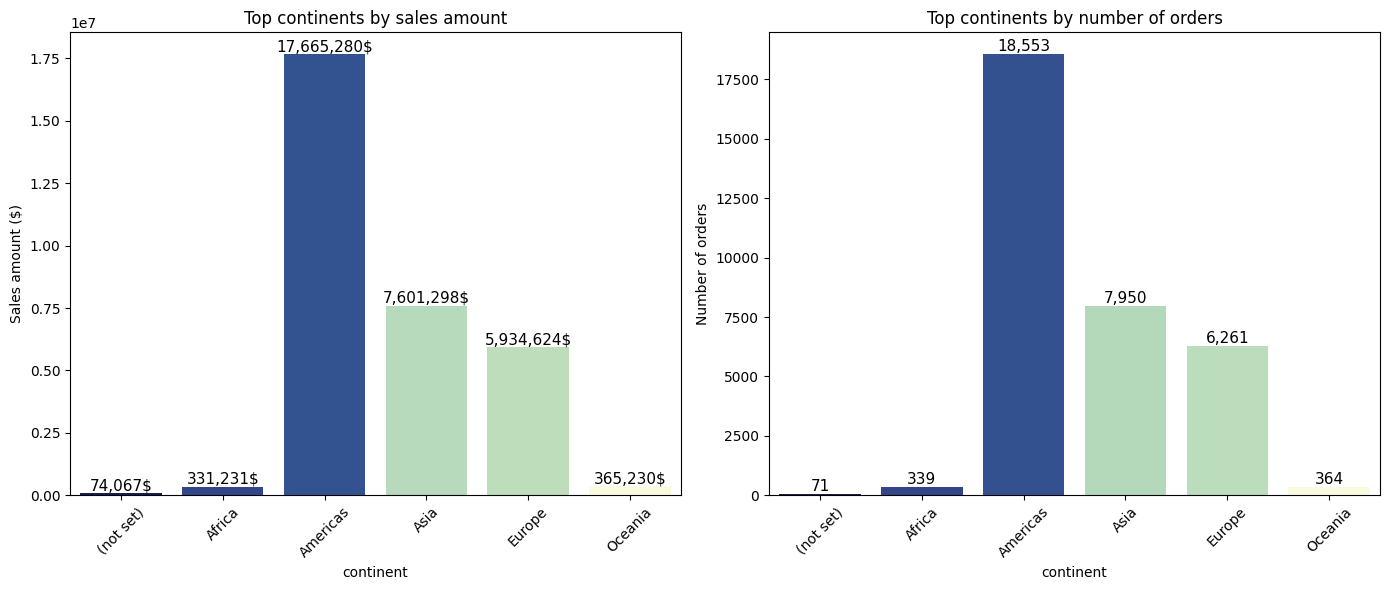

In [ ]:
import matplotlib.colors

def gradient_colors_log(values, cmap_name):
    norm = LogNorm(vmin=max(min(values), 1e-2), vmax=max(values))
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    return [cmap(norm(val)) for val in values]

continent_sales = (
    df.groupby('continent', observed=True)['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

continent_orders = (
    df.groupby('continent', observed=True)['price']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(14, 6))

colors_sales = gradient_colors_log(continent_sales['price'], 'YlGnBu')
plt.subplot(1, 2, 1)
bar1 = sns.barplot(data=continent_sales, x='continent', y='price', hue='continent', palette=colors_sales, legend=False)
plt.title('Top continents by sales amount')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11)

colors_orders = gradient_colors_log(continent_orders['price'], 'YlGnBu')
plt.subplot(1, 2, 2)
bar2 = sns.barplot(data=continent_orders, x='continent', y='price', hue='continent', palette=colors_orders, legend=False)
plt.title('Top continents by number of orders')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
# Top-3 by sales amount
top3_cont_sales = continent_sales[['continent', 'price']].head(3).copy()
top3_cont_sales.columns = ['Continent (sales)', 'Sales amount ($)']
top3_cont_sales['Sales amount ($)'] = top3_cont_sales['Sales amount ($)'].map(lambda x: f'{x:,.0f}$')

# Top-3 by number of orders
top3_cont_orders = continent_orders[['continent', 'price']].head(3).copy()
top3_cont_orders.columns = ['Continent (orders)', 'Number of orders']
top3_cont_orders['Number of orders'] = top3_cont_orders['Number of orders'].map(lambda x: f'{x:,}')

# Combine into one table
summary_continents = pd.concat(
    [top3_cont_sales.reset_index(drop=True), top3_cont_orders.reset_index(drop=True)],
    axis=1
)

print("Top-3 continents by sales amount and number of orders:")
print(summary_continents.to_string(index=False))

Top-3 continents by sales amount and number of orders:
Continent (sales) Sales amount ($) Continent (orders) Number of orders
         Americas      17,665,280$           Americas           18,553
             Asia       7,601,298$               Asia            7,950
           Europe       5,934,624$             Europe            6,261


Лідерами за сумою продажів та кількістю замовлень є континенти **Americas**, **Asia** та **Europe**. Найбільші обсяги продажів припадають на **Americas** з сумою понад **17,6 млн** доларів і **18,553** замовленнями, що свідчить про високу активність і попит у цьому регіоні. **Asia** займає друге місце з продажами на рівні **7,6** млн доларів та близько **7,950** замовлень, а **Europe** - третє з сумою близько **5,9** млн доларів і 6,261 замовленням.

Ці дані можуть бути використані для подальшої оптимізації маркетингових стратегій та фокусування ресурсів на найбільш перспективних ринках.

## По країнам

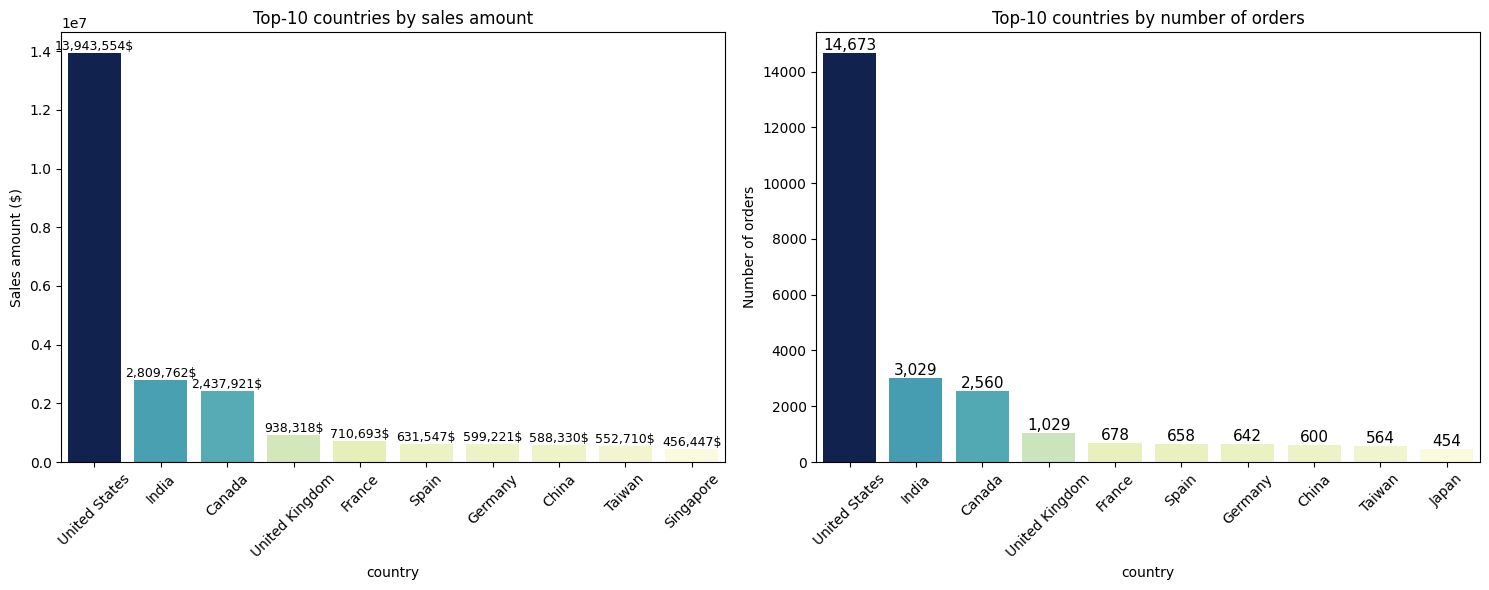

In [ ]:
country_sales = (
    df.groupby('country', observed=True)['price']
    .sum()
    .reset_index()
)
country_sales = country_sales.sort_values('price', ascending=False).head(10).reset_index(drop=True)
country_sales['country'] = country_sales['country'].astype(str)

# TOP-10 countries by number of orders
country_orders = (
    df.groupby('country', observed=True)['price']
    .count()
    .reset_index()
)
country_orders = country_orders.sort_values('price', ascending=False).head(10).reset_index(drop=True)
country_orders['country'] = country_orders['country'].astype(str)

plt.figure(figsize=(15, 6))

# Colors for sales sums
colors_sales = gradient_colors_log(country_sales['price'], 'YlGnBu')
plt.subplot(1, 2, 1)
bar1 = sns.barplot(
    data=country_sales,
    x='country',
    y='price',
    hue='country',
    palette=colors_sales,
    order=country_sales['country'].tolist(),
    legend=False
)
plt.title('Top-10 countries by sales amount')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

# Colors for number of orders
colors_orders = gradient_colors_log(country_orders['price'], 'YlGnBu')
plt.subplot(1, 2, 2)
bar2 = sns.barplot(
    data=country_orders,
    x='country',
    y='price',
    hue='country',
    palette=colors_orders,
    order=country_orders['country'].tolist(),
    legend=False
)
plt.title('Top-10 countries by number of orders')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
# Top-3 by sales amount
top3_sales = country_sales[['country', 'price']].head(3).copy()
top3_sales.columns = ['Country (sales)', 'Sales amount ($)']
top3_sales['Sales amount ($)'] = top3_sales['Sales amount ($)'].map(lambda x: f'{x:,.0f}$')

# Top-3 by number of orders
top3_orders = country_orders[['country', 'price']].head(3).copy()
top3_orders.columns = ['Country (orders)', 'Number of orders']
top3_orders['Number of orders'] = top3_orders['Number of orders'].map(lambda x: f'{x:,}')

# Combine two tables into one summary table
summary = pd.concat([top3_sales.reset_index(drop=True), top3_orders.reset_index(drop=True)], axis=1)

print("Top-3 countries by sales amount and number of orders:")
print(summary.to_string(index=False))


Top-3 countries by sales amount and number of orders:
Country (sales) Sales amount ($) Country (orders) Number of orders
  United States      13,943,554$    United States           14,673
          India       2,809,762$            India            3,029
         Canada       2,437,921$           Canada            2,560


За обсягом продажів лідирує **Сполучені Штати Америки** з показником близько **13,94** млн доларів та **14,673** замовленнями, що робить їх найважливішим ринком для платформи.

На другому місці за сумою продажів розташувалась **Індія** з показником **2,81** млн доларів та **3,029** замовленнями, що свідчить про значний потенціал зростання на цьому ринку.

Третю позицію займає **Канада**, де зафіксовано продажів на суму близько **2,44** млн доларів при **2,560** замовленнях.

Ці дані вказують на те, що основні доходи платформи формуються за рахунок трьох ключових країн, при цьому США забезпечують більшість як за обсягом продажів, так і за кількістю замовлень.



##По категоріям

Top-10 categories by sales amount:
Category                           Sales amount ($)
Sofas & armchairs                        8,388,254$
Chairs                                   6,147,749$
Beds                                     4,919,725$
Bookcases & shelving units               3,640,818$
Cabinets & cupboards                     2,336,500$
Outdoor furniture                        2,142,222$
Tables & desks                           1,790,308$
Chests of drawers & drawer units             906,562$
Bar furniture                              735,503$
Children's furniture                       467,697$


<ipython-input-125-d0c11ee48a11>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar1 = sns.barplot(


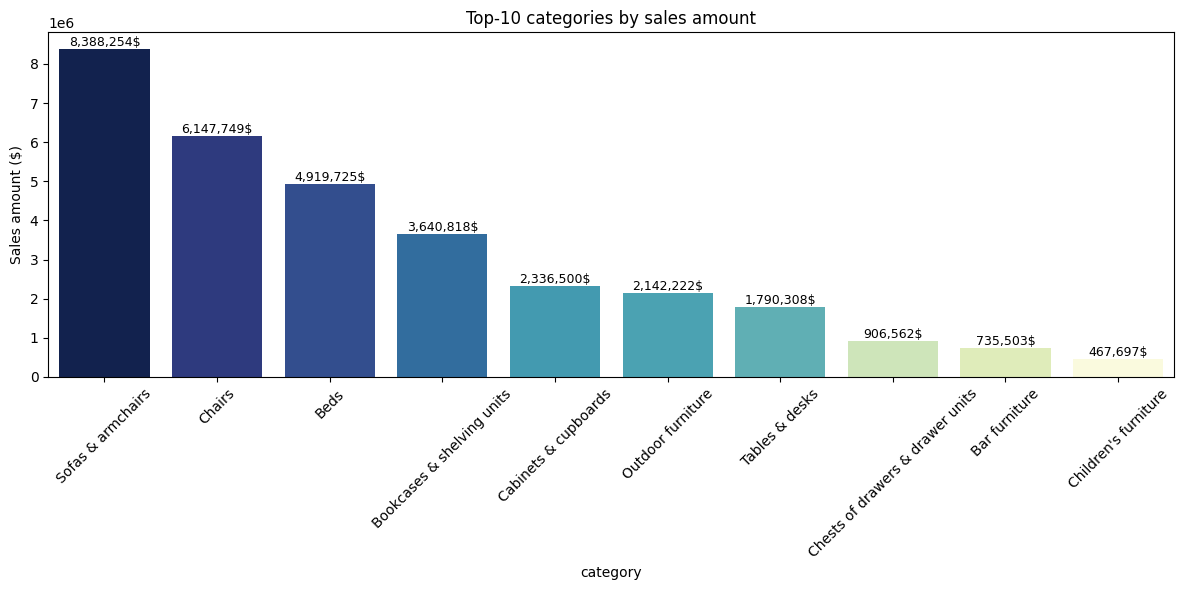

In [ ]:
# Group by categories
category_sales = (
    df.groupby('category', observed=True)['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Print table with formatting
print("Top-10 categories by sales amount:")
print(f"{'Category':<30} {'Sales amount ($)':>20}")
for _, row in category_sales.iterrows():
    category = row['category']
    sales = f"{row['price']:,.0f}$"
    print(f"{category:<30} {sales:>20}")

# Generate colors
colors_categories = gradient_colors_log(category_sales['price'], 'YlGnBu')

# Create plot
plt.figure(figsize=(12, 6))
bar1 = sns.barplot(
    data=category_sales,
    x='category',
    y='price',
    palette=colors_categories,
    order=category_sales['category'].tolist()
)
plt.title('Top-10 categories by sales amount')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


**Найприбутковішою категорією** є дивани та крісла (**Sofas & armchairs**) з продажами на суму понад **8,38** млн доларів, що свідчить про високу популярність і значну частку доходу платформи.

На другому місці розташувалися стільці (**Chairs**) із продажами понад **6,14** млн доларів, а на третьому - ліжка (**Beds**) із результатом майже **4,92** млн доларів.

Інші популярні категорії, що формують значний обсяг продажів, включають книжкові шафи та полиці (**Bookcases & shelving units**), шафи та комоди (**Cabinets & cupboards**), вуличні меблі **(Outdoor furniture**), а також столи та письмові столи (**Tables & desks**).

Top-10 categories in the country with highest sales: United States
Category                           Sales amount ($)
Sofas & armchairs                        3,707,144$
Chairs                                   2,619,774$
Beds                                     2,213,058$
Bookcases & shelving units               1,567,607$
Cabinets & cupboards                       994,546$
Outdoor furniture                          929,245$
Tables & desks                             777,865$
Chests of drawers & drawer units             382,388$
Bar furniture                              330,805$
Children's furniture                       207,575$


<ipython-input-126-75e6f110899f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar2 = sns.barplot(


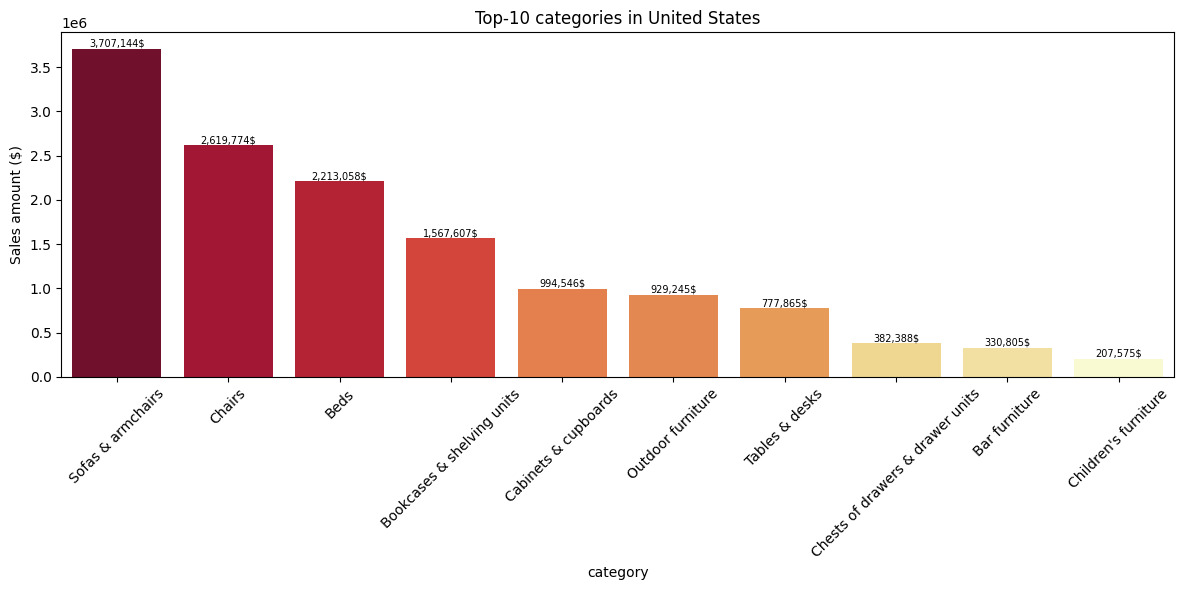

In [ ]:
# Find the country with the highest sales
top_country = df.groupby('country', observed=True)['price'].sum().idxmax()

# Filter data for this country and calculate top-10 categories
category_sales_top_country = (
    df[df['country'] == top_country]
    .groupby('category', observed=True)['price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Print formatted table
print(f"Top-10 categories in the country with highest sales: {top_country}")
print(f"{'Category':<30} {'Sales amount ($)':>20}")
for _, row in category_sales_top_country.iterrows():
    category = row['category']
    sales = f"{row['price']:,.0f}$"
    print(f"{category:<30} {sales:>20}")

# Generate colors
colors_top_country = gradient_colors_log(category_sales_top_country['price'], 'YlGnBu')

# Create plot
colors_country = gradient_colors_log(category_sales_top_country['price'], 'YlOrRd')
plt.figure(figsize=(12, 6))
bar2 = sns.barplot(
    data=category_sales_top_country,
    x='category',
    y='price',
    palette=colors_country,
    order=category_sales_top_country['category'].tolist()
)
plt.title(f'Top-10 categories in {top_country}')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()


Структура продажів у США віддзеркалює загальні тенденції: категорія диванів та крісел лідирує з продажами понад **3,7** млн доларів, далі йдуть стільці та ліжка із відповідними продажами близько **2,6** млн та **2,2** млн доларів.

Серед інших важливих категорій - книжкові шафи, шафи, вуличні меблі та столи, що також демонструють суттєвий внесок у загальний дохід.

Додатково в США помітна присутність категорій комодів (Chests of drawers & drawer units), барних меблів (Bar furniture) та дитячих меблів (Children's furniture), що підкреслює різноманітність асортименту та потенціал для подальшого розвитку

## По девайсам

Device type analysis:
Device              Sales amount ($)      % of Sales       Sessions count % of Sessions      Profit per order ($)
desktop                   18,864,040$          59.00%               19,702       58.75%                    957.47$
mobile                    12,384,226$          38.73%               13,113       39.10%                    944.42$
tablet                       723,466$           2.26%                  723        2.16%                  1,000.64$


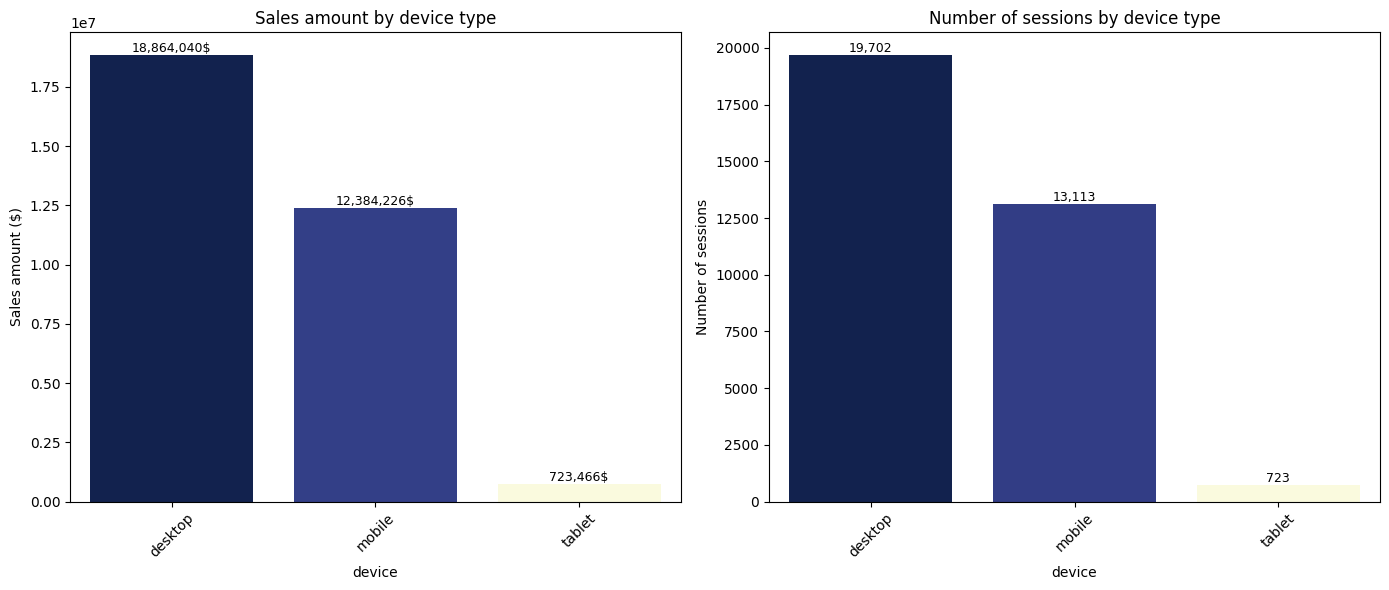

In [ ]:
# 1. Analysis by device types

# Total sales amount by device types
device_sales = (
    df.groupby('device', observed=True)['price']
    .sum()
    .reset_index()
    .sort_values('price', ascending=False)
)

# Relative share of sales (% of total sales)
total_sales = device_sales['price'].sum()
device_sales['sales_pct'] = device_sales['price'] / total_sales * 100

# Number of sessions (orders) by device types
device_sessions = (
    df.groupby('device', observed=True)['price']
    .count()
    .reset_index()
    .rename(columns={'price': 'sessions'})
    .sort_values('sessions', ascending=False)
)

# Relative share of sessions (% of total sessions)
total_sessions = device_sessions['sessions'].sum()
device_sessions['sessions_pct'] = device_sessions['sessions'] / total_sessions * 100

# Merge data for convenient output
device_summary = device_sales.merge(device_sessions, on='device')

# Calculate profit per order
device_summary['profit_per_order'] = device_summary['price'] / device_summary['sessions']

# Print formatted table
print("Device type analysis:")
print(f"{'Device':<15} {'Sales amount ($)':>20} {'% of Sales':>15} {'Sessions count':>20} {'% of Sessions':>12} {'Profit per order ($)':>25}")
for _, row in device_summary.iterrows():
    print(f"{row['device']:<15} "
          f"{row['price']:>20,.0f}$ "
          f"{row['sales_pct']:>14.2f}% "
          f"{row['sessions']:>20,} "
          f"{row['sessions_pct']:>11.2f}% "
          f"{row['profit_per_order']:>25,.2f}$")

plt.figure(figsize=(14, 6))

# Sales amount plot
plt.subplot(1, 2, 1)
colors_sales = gradient_colors_log(device_summary['price'], 'YlGnBu')
bar1 = sns.barplot(
    data=device_summary,
    x='device',
    y='price',
    hue='device',
    palette=colors_sales,
    order=device_summary['device'].tolist(),
    legend=False
)
plt.title('Sales amount by device type')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

# Sessions count plot
plt.subplot(1, 2, 2)
colors_sessions = gradient_colors_log(device_summary['sessions'], 'YlGnBu')
bar2 = sns.barplot(
    data=device_summary,
    x='device',
    y='sessions',
    hue='device',
    palette=colors_sessions,
    order=device_summary['device'].tolist(),
    legend=False
)
plt.title('Number of sessions by device type')
plt.ylabel('Number of sessions')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Найбільша частка продажів припадає на користувачів **desktop** - **59%** від загального обсягу продажів, що становить близько **18,864,040$**. Кількість сесій з desktop становить **19,702** (**58.75%** від усіх сесій). Середній прибуток з одного замовлення - **957.47** доларів .

Другу за обсягом частку займають користувачі **mobile** - **38.73%** від продажів, або приблизно **12,384,226$**. Сесій з mobile - **13,113** (**39.1%**). Середній прибуток з одного замовлення трохи нижчий - **944.42** доларів.

Користувачі **tablet** забезпечують найменший обсяг продажів - **2.26%**, або **723,466**, при **723** сесіях (**2.16%**). Водночас середній прибуток на замовлення тут найвищий - **1,000.64** доларів.

Це свідчить, що основна частина доходу генерується з desktop, але mobile-пристрої теж мають значний вплив. Незважаючи на невеликий обсяг сесій, tablet користувачі приносять найвищий середній чек, що може бути корисно врахувати для цільових маркетингових кампаній.

## По моделям

Analysis by device models:
mobile_model_name     Sales amount ($)      % of Sales       Sessions count % of Sessions      Profit per order ($)
Chrome                     8,899,524$          27.84%                9,359       27.91%                    950.91$
<Other>                    6,535,331$          20.44%                6,801       20.28%                    960.94$
Safari                     6,491,062$          20.30%                6,833       20.37%                    949.96$
iPhone                     6,420,776$          20.08%                6,819       20.33%                    941.60$
ChromeBook                 1,830,459$           5.73%                1,877        5.60%                    975.20$
Edge                         697,222$           2.18%                  741        2.21%                    940.92$
iPad                         448,854$           1.40%                  456        1.36%                    984.33$
Firefox                      421,067$           1.32

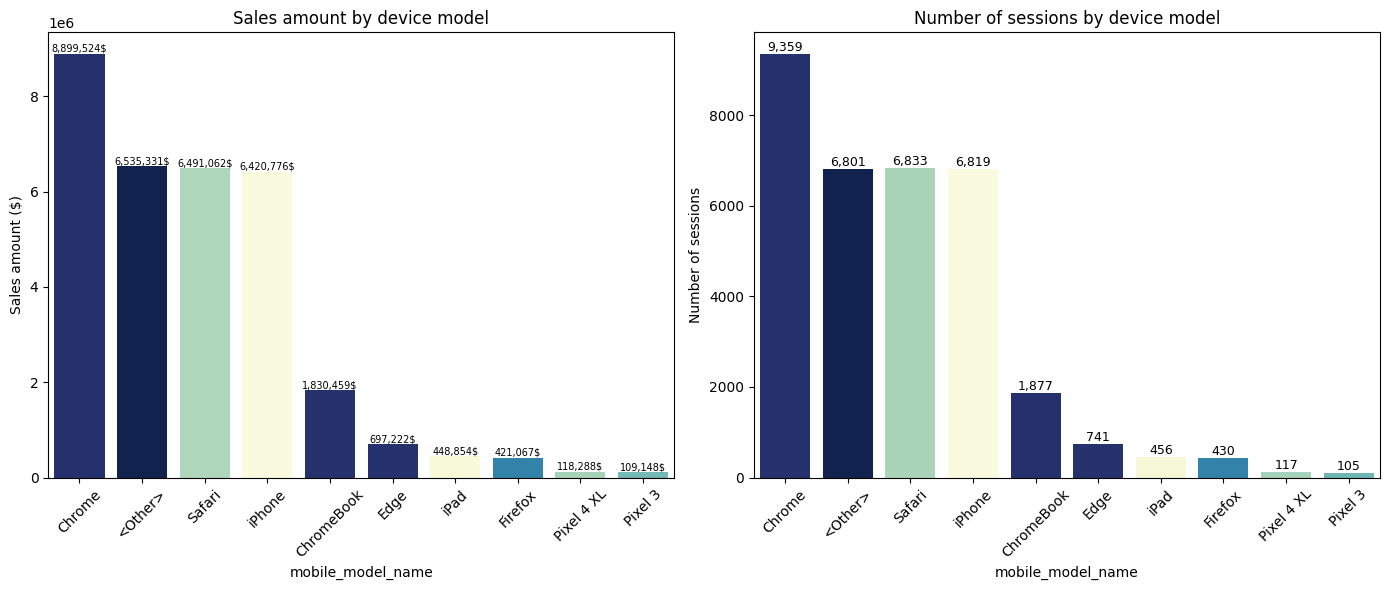

In [ ]:
# 1. Analysis by device models (mobile_model_name)

# Total sales amount by device model types
mobile_model_sales = (
    df.groupby('mobile_model_name', observed=True)['price']
    .sum()
    .reset_index()
    .sort_values('price', ascending=False)
)

# Relative share of sales (% of total sales)
total_sales = mobile_model_sales['price'].sum()
mobile_model_sales['sales_pct'] = mobile_model_sales['price'] / total_sales * 100

# Number of sessions (orders) by device model types
mobile_model_sessions = (
    df.groupby('mobile_model_name', observed=True)['price']
    .count()
    .reset_index()
    .rename(columns={'price': 'sessions'})
    .sort_values('sessions', ascending=False)
)

# Relative share of sessions (% of total sessions)
total_sessions = mobile_model_sessions['sessions'].sum()
mobile_model_sessions['sessions_pct'] = mobile_model_sessions['sessions'] / total_sessions * 100

# Merge data for convenient output
mobile_model_summary = mobile_model_sales.merge(mobile_model_sessions, on='mobile_model_name')

# Calculate profit per order
mobile_model_summary['profit_per_order'] = mobile_model_summary['price'] / mobile_model_summary['sessions']

# Print formatted table
print("Analysis by device models:")
print(f"{'mobile_model_name':<15} {'Sales amount ($)':>20} {'% of Sales':>15} {'Sessions count':>20} {'% of Sessions':>12} {'Profit per order ($)':>25}")
for _, row in mobile_model_summary.iterrows():
    print(f"{row['mobile_model_name']:<15} "
          f"{row['price']:>20,.0f}$ "
          f"{row['sales_pct']:>14.2f}% "
          f"{row['sessions']:>20,} "
          f"{row['sessions_pct']:>11.2f}% "
          f"{row['profit_per_order']:>25,.2f}$")

plt.figure(figsize=(14, 6))

# Sales amount plot
plt.subplot(1, 2, 1)
colors_sales = gradient_colors_log(mobile_model_summary['price'], 'YlGnBu')
bar1 = sns.barplot(
    data=mobile_model_summary,
    x='mobile_model_name',
    y='price',
    hue='mobile_model_name',
    palette=colors_sales,
    order=mobile_model_summary['mobile_model_name'].tolist(),
    legend=False
)
plt.title('Sales amount by device model')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=7)

# Sessions count plot
plt.subplot(1, 2, 2)
colors_sessions = gradient_colors_log(mobile_model_summary['sessions'], 'YlGnBu')
bar2 = sns.barplot(
    data=mobile_model_summary,
    x='mobile_model_name',
    y='sessions',
    hue='mobile_model_name',
    palette=colors_sessions,
    order=mobile_model_summary['mobile_model_name'].tolist(),
    legend=False
)
plt.title('Number of sessions by device model')
plt.ylabel('Number of sessions')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Найбільше продажів здійснено з пристроїв, які мають позначення **Chrome** - **8,899,524$** (**27.84%** загального обсягу), при цьому кількість сесій становила **9,359 (27.91%)**. Середній прибуток з одного замовлення - **950.91**.

На другому місці - категорія **Other**, що охоплює невизначені або рідкісні моделі. Вона генерує **6,535,331** доларів (**20.44%**) з **6,801** сесією (**20.28%**). Середній прибуток - **960.94** доларів.

**Safari** та **iPhone** показують дуже схожі результати: **6,491,062** доларів і **6,420,776** доларів відповідно (**приблизно по 20% продажів**), а кількість сесій - майже ідентична (**~6,830**). Середній прибуток трохи нижчий - близько 950$.

**ChromeBook** - ще один помітний гравець, з обсягом продажів **1,830,459$** (**5.73%**) та **1,877** сесіями (**5.60%**). Він також демонструє високий середній чек - **975.20** доларів.

Серед менш поширених моделей - **Edge**, **iPad**, **Firefox**, Pixel 4 XL та Pixel 3. Попри невелику кількість сесій (менше 2.5% кожна), вони показують конкурентні середні чеки, а **Pixel 3** навіть має найвищий показник серед усіх - **1,039.51$**.

## По джерелу трафіка

Analysis by channels:
channel             Sales amount ($)      % of Sales       Sessions count % of Sessions      Profit per order ($)
Organic Search            11,433,152$          35.76%               11,921       35.54%                    959.08$
Paid Search                8,511,049$          26.62%                9,042       26.96%                    941.28$
Direct                     7,494,924$          23.44%                7,800       23.26%                    960.89$
Social Search              2,532,106$           7.92%                2,716        8.10%                    932.29$
Undefined                  2,000,501$           6.26%                2,059        6.14%                    971.59$


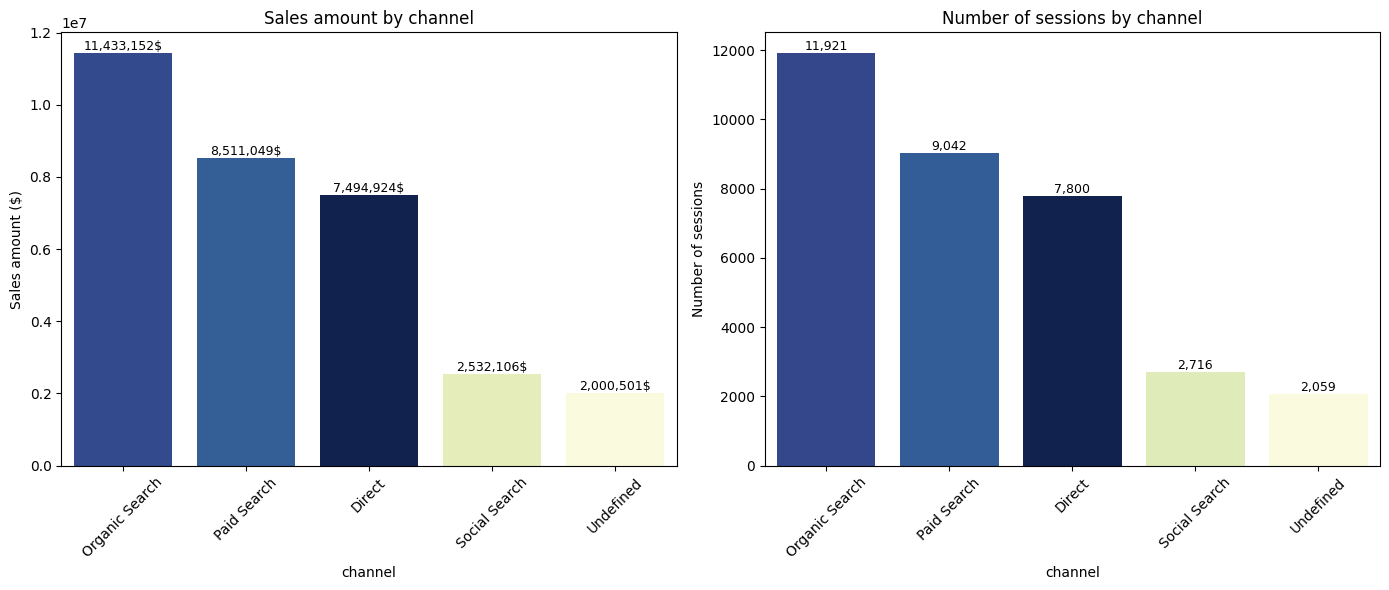

In [ ]:
# 1. Analysis by channels

# Total sales amount by channel types
channel_sales = (
    df.groupby('channel', observed=True)['price']
    .sum()
    .reset_index()
    .sort_values('price', ascending=False)
)

# Relative share of sales (% of total sales)
total_sales = channel_sales['price'].sum()
channel_sales['sales_pct'] = channel_sales['price'] / total_sales * 100

# Number of sessions (orders) by channel types
channel_sessions = (
    df.groupby('channel', observed=True)['price']
    .count()
    .reset_index()
    .rename(columns={'price': 'sessions'})
    .sort_values('sessions', ascending=False)
)

# Relative share of sessions (% of total sessions)
total_sessions = channel_sessions['sessions'].sum()
channel_sessions['sessions_pct'] = channel_sessions['sessions'] / total_sessions * 100

# Merge data for convenient output
channel_summary = channel_sales.merge(channel_sessions, on='channel')

# Calculate profit per order
channel_summary['profit_per_order'] = channel_summary['price'] / channel_summary['sessions']

# Print formatted table
print("Analysis by channels:")
print(f"{'channel':<15} {'Sales amount ($)':>20} {'% of Sales':>15} {'Sessions count':>20} {'% of Sessions':>12} {'Profit per order ($)':>25}")
for _, row in channel_summary.iterrows():
    print(f"{row['channel']:<15} "
          f"{row['price']:>20,.0f}$ "
          f"{row['sales_pct']:>14.2f}% "
          f"{row['sessions']:>20,} "
          f"{row['sessions_pct']:>11.2f}% "
          f"{row['profit_per_order']:>25,.2f}$")

plt.figure(figsize=(14, 6))

# Sales amount plot
plt.subplot(1, 2, 1)
colors_sales = gradient_colors_log(channel_summary['price'], 'YlGnBu')
bar1 = sns.barplot(
    data=channel_summary,
    x='channel',
    y='price',
    hue='channel',
    palette=colors_sales,
    order=channel_summary['channel'].tolist(),
    legend=False
)
plt.title('Sales amount by channel')
plt.ylabel('Sales amount ($)')
plt.xticks(rotation=45)
for p in bar1.patches:
    bar1.annotate(f'{p.get_height():,.0f}$', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

# Sessions count plot
plt.subplot(1, 2, 2)
colors_sessions = gradient_colors_log(channel_summary['sessions'], 'YlGnBu')
bar2 = sns.barplot(
    data=channel_summary,
    x='channel',
    y='sessions',
    hue='channel',
    palette=colors_sessions,
    order=channel_summary['channel'].tolist(),
    legend=False
)
plt.title('Number of sessions by channel')
plt.ylabel('Number of sessions')
plt.xticks(rotation=45)
for p in bar2.patches:
    bar2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Найбільшу частку прибутку принесло джерело **Organic Search** - **11,433,152** доларів або 35.76% від усіх продажів. Воно ж має і найбільшу кількість сесій - 11,921 (35.54%). Середній прибуток з одного замовлення - **959.08$**.

**Paid Search** забезпечило **8,511,049** доларів (26.62%) з 9,042 сесіями (26.96%). Незважаючи на нижчий середній чек (**941.28$**), джерело лишається одним із ключових у залученні платоспроможної аудиторії.

**Direct** канал - третій за значущістю: 7,494,924 доларів прибутку (23.44%) при 7,800 сесіях (23.26%). Середній чек становить **960.89$**, що трохи вище, ніж у Organic Search.

**Social Search** має меншу частку - 2,532,106$ (7.92%) з 2,716 сесіями (8.10%). Це свідчить про його роль як допоміжного каналу, який може мати потенціал при ефективнішій оптимізації.

Канал з міткою **Undefined** демонструє 2,000,501$ прибутку (6.26%) з 2,059 сесіями (6.14%). Цікаво, що середній чек тут - один із найвищих (971.59$), що може свідчити про специфічні, неідентифіковані джерела з високою платоспроможністю.

# Відсоток зареєстрованих користувачів підтвердив свою електронну адресу і тих хто відписався

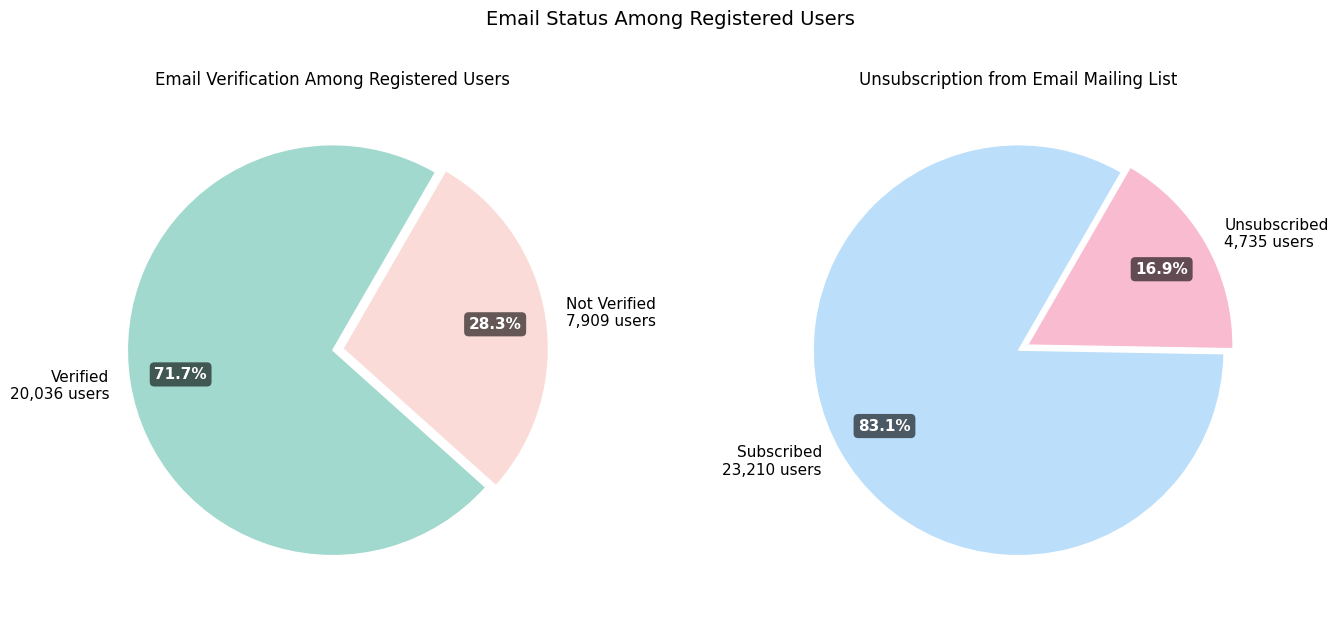

Registered users: 27945
- Verified email: 20036 (71.70%)
- Unsubscribed from mailing: 4735 (16.94%)


In [ ]:
# 1. Filter registered users
registered_users = df[df['account_id'].notna()]
total_registered = registered_users['account_id'].nunique()

# --- EMAIL VERIFICATION ---
# Counting
verified_count = registered_users[registered_users['is_verified'] == 1]['account_id'].nunique()
not_verified_count = total_registered - verified_count
verified_pct = (verified_count / total_registered) * 100

# Data for pie chart
labels_verified = [
    f'Verified\n{verified_count:,} users',
    f'Not Verified\n{not_verified_count:,} users'
]
sizes_verified = [verified_count, not_verified_count]
colors_verified = ['#A2D9CE', '#FADBD8']
explode_verified = (0, 0.05)

# --- UNSUBSCRIPTION FROM MAILING LIST ---
# Counting
unsub_count = registered_users[registered_users['is_unsubscribed'] == 1]['account_id'].nunique()
subscribed_count = total_registered - unsub_count
unsub_pct = (unsub_count / total_registered) * 100

# Data for pie chart
labels_unsub = [
    f'Subscribed\n{subscribed_count:,} users',
    f'Unsubscribed\n{unsub_count:,} users'
]
sizes_unsub = [subscribed_count, unsub_count]
colors_unsub = ['#BBDEFB', '#F8BBD0']
explode_unsub = (0, 0.05)

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First pie chart — email verification
wedges1, texts1, autotexts1 = ax1.pie(
    sizes_verified,
    explode=explode_verified,
    labels=labels_verified,
    colors=colors_verified,
    autopct='%1.1f%%',
    startangle=60,
    textprops={'color': "black", 'fontsize': 11},
    wedgeprops={'edgecolor': 'white'},
    pctdistance=0.75
)
for at in autotexts1:
    at.set_color('white')
    at.set_fontweight('bold')
    at.set_bbox(dict(boxstyle="round,pad=0.3", facecolor="black", edgecolor="none", alpha=0.6))
ax1.set_title('Email Verification Among Registered Users')

# Second pie chart — unsubscription
wedges2, texts2, autotexts2 = ax2.pie(
    sizes_unsub,
    explode=explode_unsub,
    labels=labels_unsub,
    colors=colors_unsub,
    autopct='%1.1f%%',
    startangle=60,
    textprops={'color': "black", 'fontsize': 11},
    wedgeprops={'edgecolor': 'white'},
    pctdistance=0.75
)
for at in autotexts2:
    at.set_color('white')
    at.set_fontweight('bold')
    at.set_bbox(dict(boxstyle="round,pad=0.3", facecolor="black", edgecolor="none", alpha=0.6))
ax2.set_title('Unsubscription from Email Mailing List')

plt.suptitle('Email Status Among Registered Users', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# --- Console output ---
print(f"Registered users: {total_registered}")
print(f"- Verified email: {verified_count} ({verified_pct:.2f}%)")
print(f"- Unsubscribed from mailing: {unsub_count} ({unsub_pct:.2f}%)")


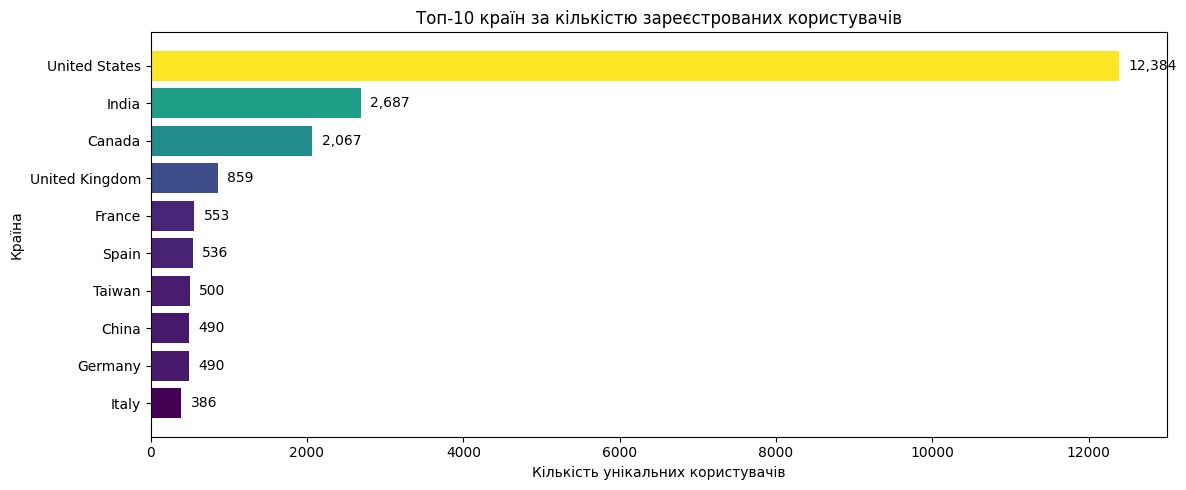

In [ ]:

users_by_country = df.groupby('country', observed=False)['account_id'].nunique().sort_values(ascending=False)


top_countries = users_by_country.head(10)


top_countries_df = top_countries.reset_index()
top_countries_df.columns = ['country', 'user_count']


colors = gradient_colors_log(top_countries_df['user_count'], 'viridis')


plt.figure(figsize=(12,5))

bars = plt.barh(top_countries_df['country'], top_countries_df['user_count'], color=colors)
plt.gca().invert_yaxis()  # Найбільше зверху

plt.xlabel('Кількість унікальних користувачів')
plt.ylabel('Країна')
plt.title('Топ-10 країн за кількістю зареєстрованих користувачів')

# Додаємо підписи чисел праворуч від барів
for bar, count in zip(bars, top_countries_df['user_count']):
    plt.text(bar.get_width() + max(top_countries_df['user_count']) * 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()



t-test : t=0.659, p=0.510
Mann-Whitney U : stat=543100.0, p=0.168

Unsubscribed: 447/4735 users (buyers), which is 9.4%
Subscribed: 2334/23210 users (buyers), which is 10.1%
ℹ No statistically significant difference in purchase sums between groups was found.


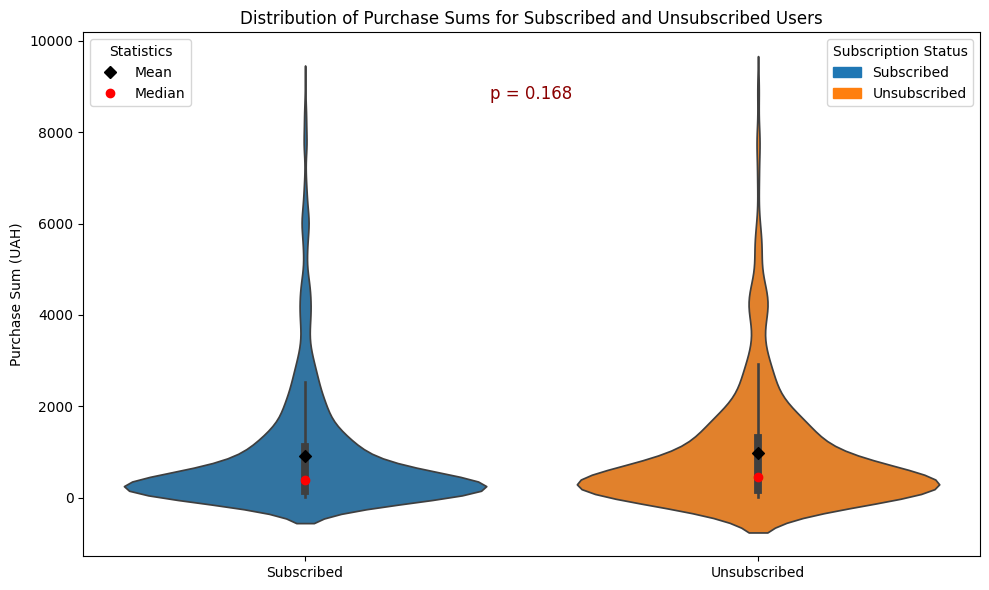

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Filter valid purchases — keep rows with price > 0
df_sales = df.dropna(subset=['price'])
df_sales = df_sales[df_sales['price'] > 0]

# Aggregate data per user (account_id): sum purchases, take max is_unsubscribed (0 or 1)
df_users = df_sales.groupby('account_id', as_index=False).agg({
    'price': 'sum',
    'is_unsubscribed': 'max'
})

# Separate two user groups by subscription status
df_unsub = df_users[df_users['is_unsubscribed'] == 1]['price']  # unsubscribed
df_sub = df_users[df_users['is_unsubscribed'] == 0]['price']    # subscribed

# t-test to check difference between groups (assuming unequal variance)
t_stat, p_t = ttest_ind(df_unsub, df_sub, equal_var=False)
print(f"t-test : t={t_stat:.3f}, p={p_t:.3f}")

# Mann-Whitney test (non-parametric test for independent samples)
stat, p_mw = mannwhitneyu(df_unsub, df_sub, alternative='two-sided')
print(f"Mann-Whitney U : stat={stat}, p={p_mw:.3f}")

# Total number of accounts by status (from full dataset)
total_unsub = df[df['is_unsubscribed'] == 1]['account_id'].nunique()
total_sub = df[df['is_unsubscribed'] == 0]['account_id'].nunique()

# Number of buyers (those with purchase sum > 0)
buyers_unsub = df_users[(df_users['is_unsubscribed'] == 1) & (df_users['price'] > 0)].shape[0]
buyers_sub = df_users[(df_users['is_unsubscribed'] == 0) & (df_users['price'] > 0)].shape[0]

print(f"\nUnsubscribed: {buyers_unsub}/{total_unsub} users (buyers), which is {buyers_unsub/total_unsub:.1%}")
print(f"Subscribed: {buyers_sub}/{total_sub} users (buyers), which is {buyers_sub/total_sub:.1%}")

# Conclusion about statistical significance
if p_t < 0.05 and p_mw < 0.05:
    print("There is a statistically significant difference in purchase sums between subscribed and unsubscribed users.")
else:
    print("ℹ No statistically significant difference in purchase sums between groups was found.")

# Visualization of purchase sums distribution
palette = {False: '#1f77b4', True: '#ff7f0e'}

plt.figure(figsize=(10,6))
sns.violinplot(
    x='is_unsubscribed',
    y='price',
    hue='is_unsubscribed',
    data=df_users,
    palette=palette,
    legend=False
)

# Add mean values per group (black diamonds)
group_means = df_users.groupby('is_unsubscribed')['price'].mean()
plt.scatter([0, 1], group_means.values, color='black', marker='D', zorder=10)

# Add medians (red circles)
group_medians = df_users.groupby('is_unsubscribed')['price'].median()
plt.scatter([0, 1], group_medians.values, color='red', marker='o', zorder=10)

# Annotate p-value (Mann-Whitney)
plt.text(0.5, df_users['price'].max() * 0.98,
         f"p = {p_mw:.3f}", ha='center', fontsize=12, color='darkred')

# Legends for colors and statistics
patch_sub = mpatches.Patch(color=palette[False], label='Subscribed')
patch_unsub = mpatches.Patch(color=palette[True], label='Unsubscribed')
legend1 = plt.legend(handles=[patch_sub, patch_unsub], title='Subscription Status', loc='upper right')

mean_marker = mlines.Line2D([], [], color='black', marker='D', linestyle='None', label='Mean')
median_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Median')
legend2 = plt.legend(handles=[mean_marker, median_marker], title='Statistics', loc='upper left')

plt.gca().add_artist(legend1)

plt.xticks([0, 1], ['Subscribed', 'Unsubscribed'])
plt.ylabel('Purchase Sum (UAH)')
plt.xlabel('')
plt.title('Distribution of Purchase Sums for Subscribed and Unsubscribed Users')
plt.tight_layout()
plt.show()


Усього зареєстровано **27,945** користувачів, з яких **71.70%** підтвердили email, а **16.94%** відписалися від розсилки. Це свідчить про загалом хороший рівень залучення, але також вказує на можливі точки покращення — зокрема в процесі комунікації та утримання користувачів.

Попри наявність зареєстрованих акаунтів, лише **7.99%** сесій містять дані акаунта, що натякає на низьку мотивацію користувачів повертатися під власним профілем або взагалі авторизуватись. Це, ймовірно, знижує ефективність персоналізації та повторного маркетингу.

**Топ 3** по кількості зареєстрованих користувачів дзеркально до продаж займають - **США, Індія та Канада**

**Результати статистичного аналізу**

Було проведено t-test та Mann–Whitney U-тест для порівняння обсягів покупок серед користувачів, які підписані та відписані від розсилки. Результати:

* t = 0.659, p = **0.510**

* U = 543100.0, p = **0.168**

Це означає, **що статистично значущої різниці у сумах покупок між групами не виявлено**. Частка покупців серед:

* Відписаних - **9.4% (447 з 4735 користувачів)**;

* Підписаних - **10.1% (2334 з 23210 користувачів)**.

Таким чином, хоча підписані користувачі мають трохи вищий відсоток покупок, ця різниця не є статистично значущою.

**Висновок**

Реєстрація та підписка наразі не впливають суттєво на поведінку користувача. Варто переосмислити роль цих елементів у воронці продажу.

Необхідно впровадити реальні переваги для зареєстрованих і підписаних користувачів: персоналізовані пропозиції, доступ до знижок, зручний кабінет користувача.

Варто оптимізувати процес авторизації (наприклад, через соціальні логіни або збереження входу), щоби підвищити відсоток залогінених сесій.

Загалом, база зареєстрованих користувачів є потенційно цінною, однак нині її ефективність залишається невисокою.

 # Аналіз продажів
 ## Загальний

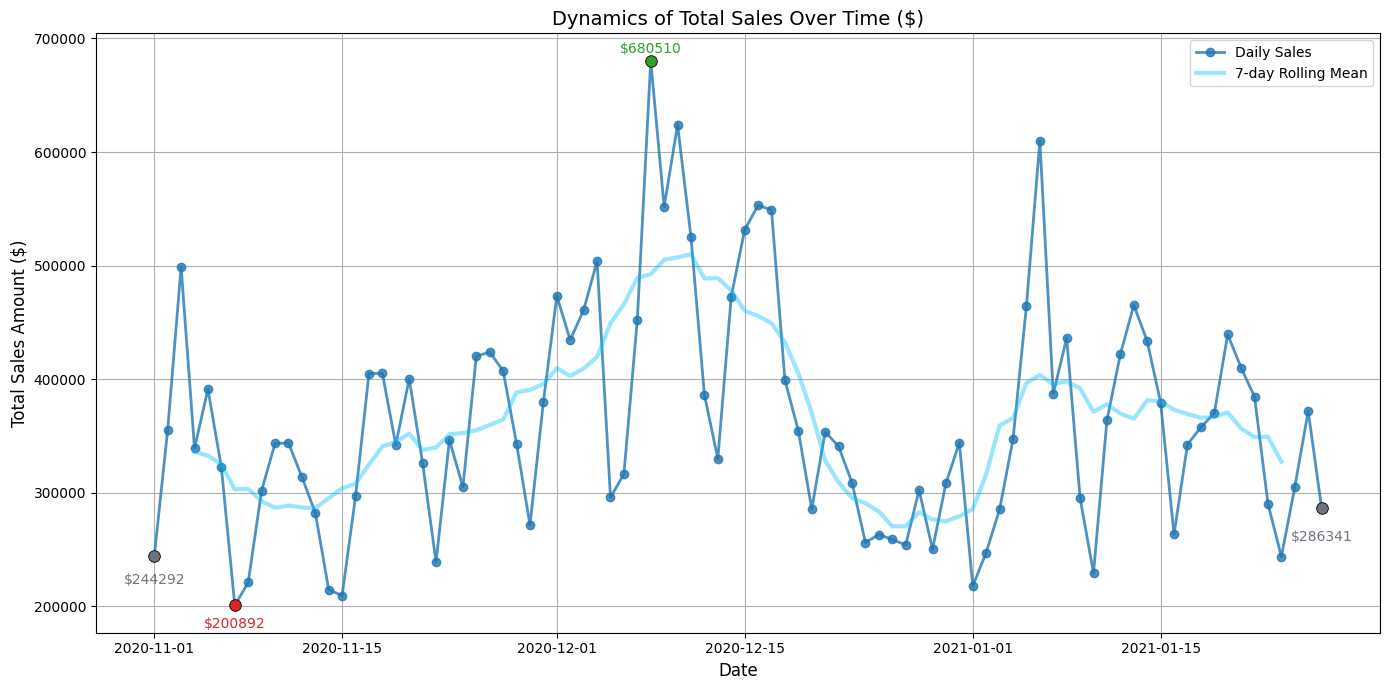

In [ ]:
# Group by date and calculate total sales per day
daily_sales = df_sales.groupby('date')['price'].sum().reset_index()

# Calculate rolling mean (7-day window)
window = 7
daily_sales['rolling_mean'] = daily_sales['price'].rolling(window=window, center=True).mean()

# Find indexes of key points
idx_max = daily_sales['price'].idxmax()
idx_min = daily_sales['price'].idxmin()
idx_start = 0
idx_end = len(daily_sales) - 1

# Key points
key_points = daily_sales.loc[[idx_start, idx_end, idx_max, idx_min]]

plt.figure(figsize=(14,7))

# Plot daily sales
plt.plot(daily_sales['date'], daily_sales['price'], marker='o', linestyle='-', color='tab:blue', alpha=0.8, linewidth=2, label='Daily Sales')

# Rolling mean line
plt.plot(daily_sales['date'], daily_sales['rolling_mean'], color='deepskyblue', alpha=0.4, linewidth=3, label=f'{window}-day Rolling Mean')

# Colors for key points
colors_points = {
    idx_start: '#6c757d',
    idx_end: '#6c757d',
    idx_max: '#2ca02c',
    idx_min: '#d62728'
}

for idx, row in key_points.iterrows():
    plt.scatter(row['date'], row['price'], color=colors_points[idx], s=70, zorder=5, edgecolor='black', linewidth=0.6)

for idx, row in key_points.iterrows():
    if idx == idx_max:
        plt.text(row['date'], row['price'] * 1.01, f"${row['price']:.0f}", ha='center', color=colors_points[idx], fontsize=10, fontweight='normal')
    else:
        plt.text(row['date'], row['price'] * 0.9, f"${row['price']:.0f}", ha='center', color=colors_points[idx], fontsize=10, fontweight='normal')

plt.title('Dynamics of Total Sales Over Time ($)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales Amount ($)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Monthly Summary Data (Revenue and Number of Sessions):
     month     revenue  sessions
2020-11-01  9,897,515$     10540
2020-12-01 12,423,439$     12903
2021-01-01  9,650,777$     10095

Top 5 Days by Sales Amount:
date
2020-12-08    680,510$
2020-12-10    624,105$
2021-01-06    609,764$
2020-12-16    553,135$
2020-12-09    551,812$
Name: price, dtype: object


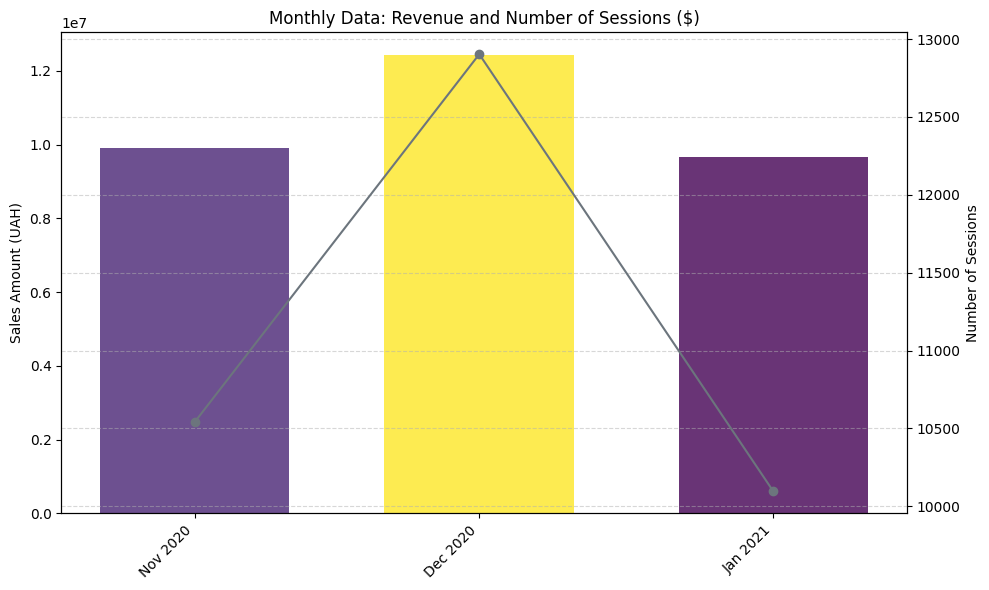

In [ ]:
import matplotlib.dates as mdates

# Aggregate data by month (Revenue and number of sessions)
df_sales['month'] = df_sales['date'].dt.to_period('M')
monthly_summary = df_sales.groupby('month').agg(
    revenue=('price', 'sum'),
    sessions=('session_id', 'nunique')
).reset_index()

# Convert month to Timestamp for easier display
monthly_summary['month'] = monthly_summary['month'].dt.to_timestamp()

# Formatted print of monthly summary data
monthly_summary_print = monthly_summary.copy()
monthly_summary_print['revenue'] = monthly_summary_print['revenue'].apply(lambda x: f"{x:,.0f}$")

print("\nMonthly Summary Data (Revenue and Number of Sessions):")
print(monthly_summary_print[['month', 'revenue', 'sessions']].to_string(index=False))


# Top 5 days by sales amount
daily_revenue = df_sales.groupby('date')['price'].sum().sort_values(ascending=False).head(5)
print("\nTop 5 Days by Sales Amount:")
print(daily_revenue.apply(lambda x: f"{x:,.0f}$"))


# Visualization
fig, ax1 = plt.subplots(figsize=(10,6))

# Get bar colors via gradient
bar_colors = gradient_colors_log(monthly_summary['revenue'], 'viridis')

# Barplot of revenue with gradient
ax1.bar(monthly_summary['month'], monthly_summary['revenue'], width=20, alpha=0.8, color=bar_colors)
ax1.set_ylabel('Sales Amount (UAH)')
ax1.tick_params(axis='y')

# Line plot of sessions in a more muted color
ax2 = ax1.twinx()
ax2.plot(monthly_summary['month'], monthly_summary['sessions'], color='#6c757d', marker='o')  # gray shade
ax2.set_ylabel('Number of Sessions')
ax2.tick_params(axis='y')

# Format X axis - month labels
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

plt.title('Monthly Data: Revenue and Number of Sessions ($)')
plt.xlabel('Month')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Найвищі денні продажі** припали на **8 грудня 2020 року** - 680,509.50$. Інші піки: 10.12, 9.12, 16.12 та 6.01, з обсягами понад **550** тис доларів.

**Місяць з найбільшим обсягом продажів** - грудень 2020: **12.42 млн$ при 12,903 сесіях.**

Для порівняння:

листопад 2020 - 9.89$ млн, 10,540 сесій

січень 2021 - 9.65$ млн, 10,095 сесій

Найвищі продажі концентруються у грудні, що відповідає святковому сезонному попиту.

Загалом, зростання трафіку напряму корелює зі зростанням продажів — дні з піками сесій збігаються з піками доходу.

Після свят - спад активності як по сесіях, так і по замовленнях.

## За топ-3 континентами/джерелами трафіку/типом девайсів

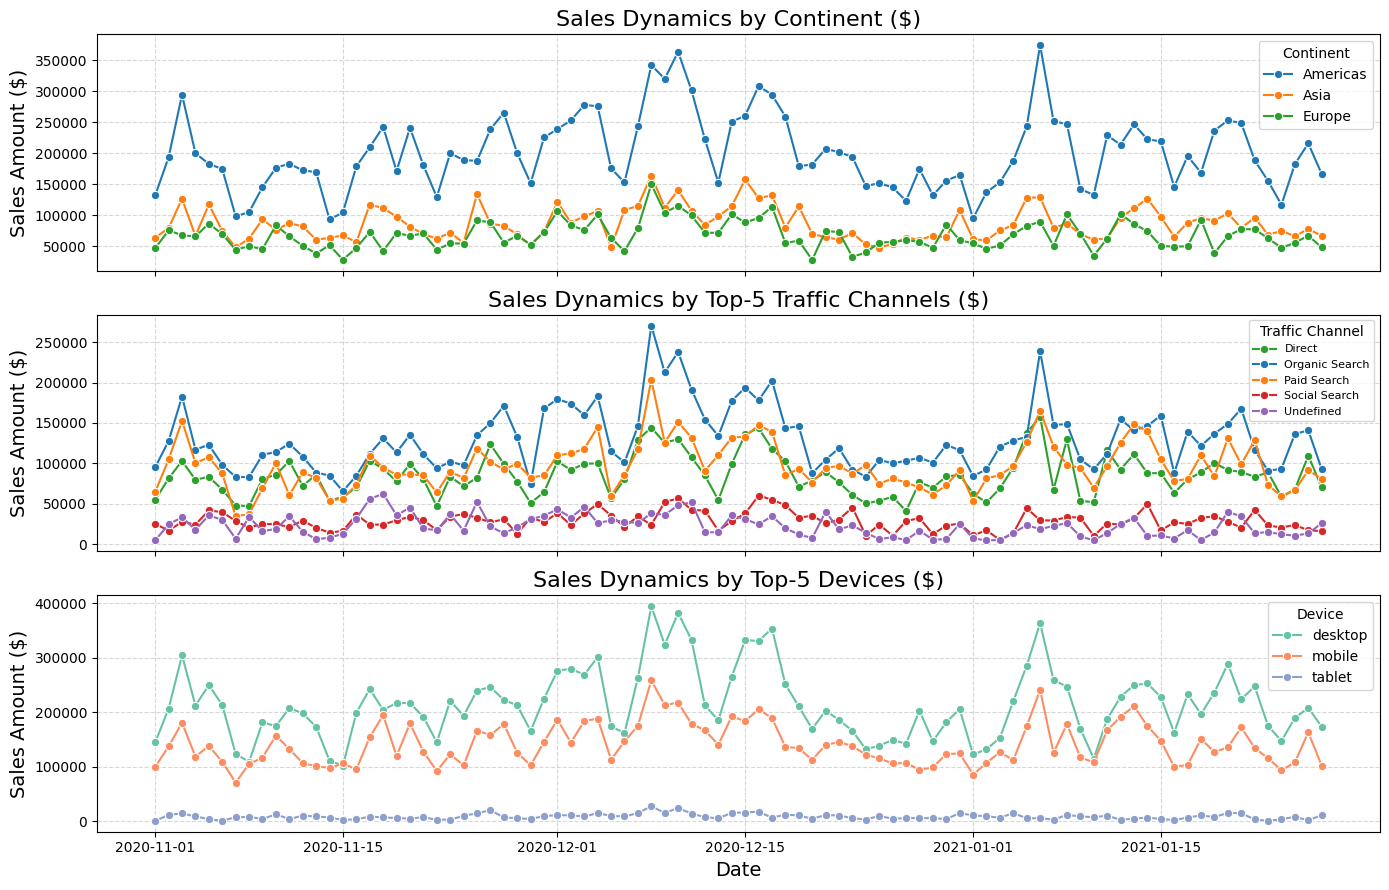

In [ ]:
# List of required continents
valid_continents = ['Americas', 'Asia', 'Europe']

# Filter data by continents
df_continent = df_sales[df_sales['continent'].isin(valid_continents)].copy()

# Group by date and continent
continent_daily_sales = df_continent.groupby(['date', 'continent'], observed=True)['price'].sum().reset_index()

# Clean categories (if categorical type)
if isinstance(continent_daily_sales['continent'].dtype, pd.CategoricalDtype):
    continent_daily_sales['continent'] = continent_daily_sales['continent'].cat.remove_unused_categories()

# Palette for continents
continent_palette = {
    'Americas': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c'
}

# Group by date and traffic channel
channel_daily_sales = df_sales.groupby(['date', 'channel'], observed=True)['price'].sum().reset_index()

# Clean categories for channel
if isinstance(channel_daily_sales['channel'].dtype, pd.CategoricalDtype):
    channel_daily_sales['channel'] = channel_daily_sales['channel'].cat.remove_unused_categories()

# Define top 5 channels by total sales amount
top_channels = (channel_daily_sales.groupby('channel', observed=False)['price'].sum()
                .sort_values(ascending=False).head(5).index.tolist())


# Filter by top 5 channels
channel_daily_sales = channel_daily_sales[channel_daily_sales['channel'].isin(top_channels)]

# Palette for top 5 channels (automatic)
channel_palette = sns.color_palette('tab10', n_colors=len(top_channels))
channel_palette = dict(zip(top_channels, channel_palette))


# Group by date and device
device_daily_sales = df_sales.groupby(['date', 'device'], observed=True)['price'].sum().reset_index()

# Clean categories for device (if needed)
if isinstance(device_daily_sales['device'].dtype, pd.CategoricalDtype):
    device_daily_sales['device'] = device_daily_sales['device'].cat.remove_unused_categories()

# Define top 5 devices by sales amount
top_devices = (device_daily_sales.groupby('device', observed=False)['price'].sum()
               .sort_values(ascending=False).head(5).index.tolist())

# Filter by top 5 devices
device_daily_sales = device_daily_sales[device_daily_sales['device'].isin(top_devices)]

# Palette for top 5 devices (automatic)
device_palette = sns.color_palette('Set2', n_colors=len(top_devices))
device_palette = dict(zip(top_devices, device_palette))


# Plot three charts in one figure (stacked vertically)
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Sales dynamics by continent
sns.lineplot(
    data=continent_daily_sales,
    x='date',
    y='price',
    hue='continent',
    palette=continent_palette,
    marker='o',
    ax=axes[0]
)
axes[0].set_title('Sales Dynamics by Continent ($)', fontsize=16)
axes[0].set_ylabel('Sales Amount ($)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(title='Continent', fontsize=10)

# Sales dynamics by top-5 traffic channels
sns.lineplot(
    data=channel_daily_sales,
    x='date',
    y='price',
    hue='channel',
    palette=channel_palette,
    marker='o',
    ax=axes[1]
)
axes[1].set_title('Sales Dynamics by Top-5 Traffic Channels ($)', fontsize=16)
axes[1].set_ylabel('Sales Amount ($)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(title='Traffic Channel', fontsize=8)

# Sales dynamics by top-5 devices
sns.lineplot(
    data=device_daily_sales,
    x='date',
    y='price',
    hue='device',
    palette=device_palette,
    marker='o',
    ax=axes[2]
)
axes[2].set_title('Sales Dynamics by Top-5 Devices ($)', fontsize=16)
axes[2].set_xlabel('Date', fontsize=14)
axes[2].set_ylabel('Sales Amount ($)', fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend(title='Device', fontsize=10)

plt.tight_layout()
plt.show()



Динаміка продажів за **країнами, типами пристроїв та каналами трафіку** загалом **віддзеркалює загальні тренди** — основні піки також припадають на грудень 2020 – січень 2021. Незалежно від джерела чи пристрою, зростання сесій призводить **до зростання доходу**, а спад трафіку — до **просідання продажів**. Це свідчить про узгодженість поведінки користувачів по різних сегментах.

#Зведені таблиці
## Кількість сесій за каналами трафіку та типами девайсів:


In [ ]:
# Filter data to remove missing values in 'channel' and 'device'
df_filtered = df.dropna(subset=['channel', 'device'])

# Group by 'channel' and 'device', count unique sessions
sessions_pivot = df_filtered.groupby(['channel', 'device'], observed=False)['session_id'].nunique().reset_index()

# Convert to pivot table
sessions_pivot_table = sessions_pivot.pivot(index='channel', columns='device', values='session_id').fillna(0).astype(int)

print("Pivot Table: Number of Sessions by Channel and Device")
display(sessions_pivot_table)


Pivot Table: Number of Sessions by Channel and Device


device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


Найбільше сесій зафіксовано з **desktop** через **Organic Search (72,622)**, а загалом **desktop** домінує за всіма каналами. **Mobile** посідає друге місце, з особливою активністю в каналах **Direct** і **Paid Search**. **Tablet** має найменшу кількість сесій по всіх джерелах, становлячи менш як **5%** загального трафіку

## Загальний обсяг продажів за категоріями товарів (топ-10) у різних країнах (топ-5)


In [ ]:
import pandas as pd

# Assume df_sales already exists with columns 'category', 'country', 'price'

# Top 10 categories and top 5 countries
top_categories = df_sales.groupby('category', observed=True)['price'].sum().nlargest(10).index
top_countries = df_sales.groupby('country', observed=True)['price'].sum().nlargest(5).index

# Filtering
df_filtered = df_sales[
    df_sales['category'].isin(top_categories) &
    df_sales['country'].isin(top_countries)
].copy()

# Remove unused categories
if isinstance(df_filtered['country'].dtype, pd.CategoricalDtype):
    df_filtered['country'] = df_filtered['country'].cat.remove_unused_categories()
if isinstance(df_filtered['category'].dtype, pd.CategoricalDtype):
    df_filtered['category'] = df_filtered['category'].cat.remove_unused_categories()

# Grouping
category_country_sales = df_filtered.groupby(['category', 'country'], observed=True)['price'].sum().reset_index()

# Pivot table
pivot_table = category_country_sales.pivot(index='category', columns='country', values='price').fillna(0)

# Add a column with the max value in the row (max revenue per country for each category)
pivot_table['MaxValue'] = pivot_table.max(axis=1)

# Sort by this column descending
pivot_table_sorted = pivot_table.sort_values('MaxValue', ascending=False)

# Drop the MaxValue column
pivot_table_sorted = pivot_table_sorted.drop(columns='MaxValue')

# Format as currency
pivot_table_formatted = pivot_table_sorted.style.format('${:,.0f}')

print("Pivot Table: Total Sales by Product Categories (Top 10) in Different Countries (Top 5):")
display(pivot_table_formatted)


Pivot Table: Total Sales by Product Categories (Top 10) in Different Countries (Top 5), sorted by max revenue per category:


country,Canada,France,India,United Kingdom,United States
category,,,,,
Sofas & armchairs,"$692,428","$187,735","$788,430","$234,812","$3,707,144"
Chairs,"$417,741","$134,029","$544,309","$188,519","$2,619,774"
Beds,"$354,772","$116,414","$358,320","$133,816","$2,213,058"
Bookcases & shelving units,"$278,982","$73,830","$364,507","$113,988","$1,567,607"
Cabinets & cupboards,"$181,802","$59,102","$191,888","$71,684","$994,546"
Outdoor furniture,"$185,323","$40,486","$162,289","$57,002","$929,245"
Tables & desks,"$132,678","$42,299","$186,158","$49,374","$777,865"
Chests of drawers & drawer units,"$71,952","$21,544","$73,111","$36,784","$382,388"
Bar furniture,"$51,724","$11,199","$57,657","$22,103","$330,805"


Найбільші продажі у категорії **Sofas & armchairs**, особливо в **США** — понад **3,7 млн $**. Наступні за обсягом — **Chairs та Beds**.

**США** лідирують за всіма категоріями, **Індія** та **Канада** — на другому і третьому місцях з приблизно втричі меншими продажами. **Великобританія** і **Франція** мають найнижчі обсяги, але структура продажів схожа.

Менші категорії, як **Bar furniture** і **Children’s** **furniture**, мають найнижчі показники в усіх країнах.

##Загальний дохід за мовами користувачів та континентами

In [ ]:
# Filter data without missing values
df_lang_continent = df_sales.dropna(subset=['language', 'continent'])

# Create pivot table
pivot_lang_continent = pd.pivot_table(
    df_lang_continent,
    values='price',
    index='language',
    columns='continent',
    aggfunc='sum',
    fill_value=0,
    observed=False
)

# Sort columns (continents) by total revenue
continent_totals = pivot_lang_continent.sum(axis=0)
sorted_columns = continent_totals.sort_values(ascending=False).index
pivot_lang_continent = pivot_lang_continent[sorted_columns]

# Sort languages (rows) by revenue in the first (most profitable) continent
main_continent = sorted_columns[0]
pivot_lang_continent = pivot_lang_continent.sort_values(by=main_continent, ascending=False)

pivot_lang_continent_fmt = pivot_lang_continent.map(lambda x: f"{x:,.0f}$")

# Output
print("Pivot Table: Total Revenue by User Languages and Continents")
display(pivot_lang_continent_fmt)


Pivot Table: Total Revenue by User Languages and Continents (continents and languages sorted)


continent,Americas,Asia,Europe,Oceania,Africa,(not set)
language,,,,,,
en-us,"8,061,810$","3,583,372$","2,749,108$","156,921$","138,592$","26,067$"
en-gb,"1,189,684$","512,733$","423,127$","36,248$","16,974$","2,549$"
en,"568,945$","231,549$","171,161$","3,718$","18,391$","1,773$"
zh,"568,267$","270,932$","181,853$","15,763$","16,225$",0$
en-ca,"429,895$","180,826$","150,852$","8,056$","7,674$","1,550$"
fr,"340,394$","127,423$","103,708$","4,309$","3,120$",70$
es-es,"261,632$","134,398$","102,991$","6,771$","8,036$",745$
ko,"182,514$","47,236$","59,922$","3,637$",430$,"4,790$"
de,"126,299$","64,234$","56,701$","5,045$","4,810$",0$


Найбільший дохід приносить мова **en-us**, особливо в **Americas** (**$8 млн**), але також суттєво в **Asia** і **Europe**. Інші англомовні варіанти (en-gb, en, en-ca) теж генерують значні продажі.

Серед інших мов помітні **zh** (китайська), **fr** (французька) і **es-es** (іспанська) — з помірними доходами по різних континентах.

**Americas** лідирує за доходами майже для всіх мов, Asia і Europe — другі за обсягами. Менші континенти (**Oceania**, **Africa**) мають суттєво нижчі показники.

#Статистичний аналіз
##Перевірка кореляції між кількістю сесій та продажами.



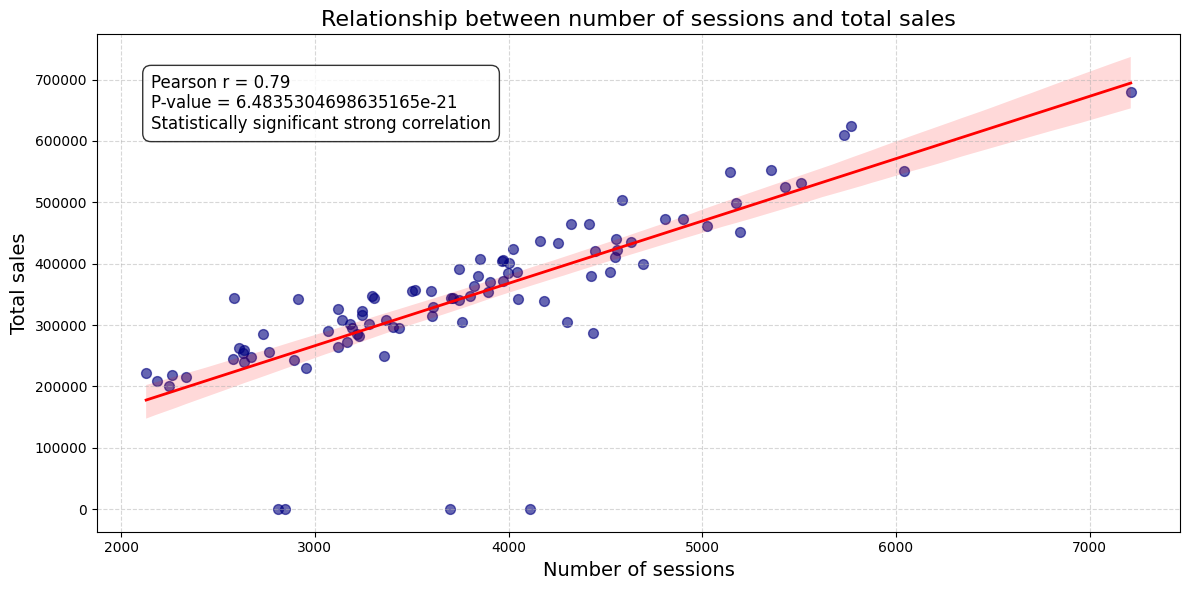

In [ ]:
from scipy.stats import pearsonr, shapiro, normaltest, levene

# Group data by dates: count the number of sessions and sum of sales
df_daily = df.groupby("date").agg(
    total_sessions=("session_id", "count"),
    total_sales=("price", "sum")
).reset_index()

# Calculate Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(df_daily["total_sessions"], df_daily["total_sales"])

# Classification of correlation strength for interpretation
def interpret_correlation(r, p):
    if p >= 0.05:
        return "Correlation is not statistically significant"
    elif abs(r) > 0.7:
        return "Statistically significant strong correlation"
    elif 0.4 < abs(r) <= 0.7:
        return "Statistically significant moderate correlation"
    elif 0.1 < abs(r) <= 0.4:
        return "Statistically significant weak correlation"
    else:
        return "Correlation is very weak or absent"

# Visualization
plt.figure(figsize=(12, 6))
sns.regplot(
    x="total_sessions",
    y="total_sales",
    data=df_daily,
    scatter_kws={"alpha": 0.6, "s": 50, "color": "navy"},
    line_kws={"color": "red", "lw": 2}
)

plt.title("Relationship between number of sessions and total sales", fontsize=16)
plt.xlabel("Number of sessions", fontsize=14)
plt.ylabel("Total sales", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Add correlation results text on the plot
plt.text(
    x=plt.gca().get_xlim()[0] + (plt.gca().get_xlim()[1] - plt.gca().get_xlim()[0]) * 0.05,
    y=plt.gca().get_ylim()[1] * 0.8,
    s=(
        f"Pearson r = {corr_coef:.2f}\n"
        f"P-value = {p_value}\n"
        f"{interpret_correlation(corr_coef, p_value)}"
    ),
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()


Виявлено **сильний позитивний зв’язок між кількістю сесій та сумою продажів** із коефіцієнтом кореляції Пірсона близько **0.79**. Цей показник свідчить про високу залежність: зростання трафіку (кількості сесій) тягне за собою збільшення обсягів продажів.

При цьому p-значення (приблизно 6.48e-21) демонструє **високу статистичну значущість кореляції**

Отже, маркетингові зусилля, спрямовані на залучення більшої кількості відвідувачів, ймовірно, позитивно вплинуть на збільшення продажів.

## Кореляція продажів по континентам.

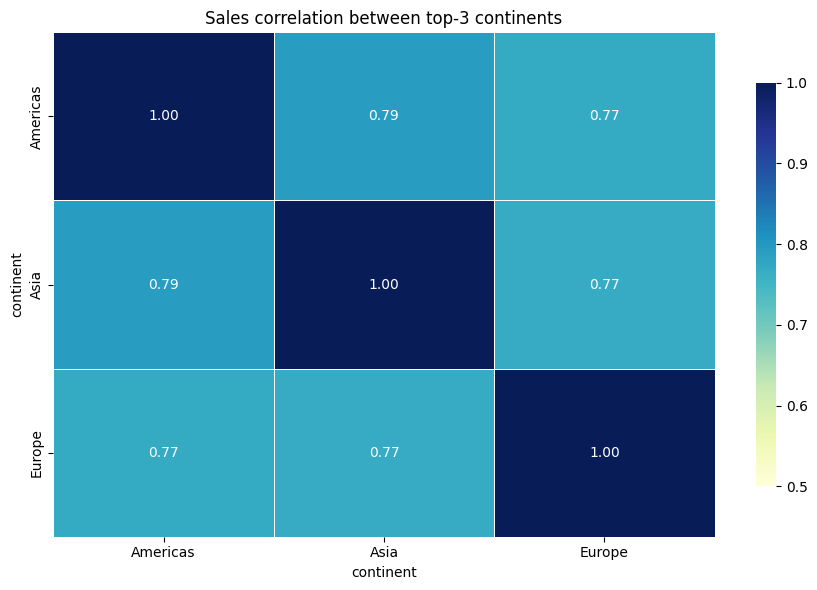

P-values for testing significance of correlations between top-3 continents:


continent,Americas,Asia,Europe
continent,,,
Americas,1.000000e+00,5.409190e-21,2.671446e-19
Asia,5.409190e-21,1.000000e+00,3.864948e-19
Europe,2.671446e-19,3.864948e-19,1.000000e+00


In [ ]:
# 1. Aggregate sales by dates and continents (observed=True to avoid warnings)
df_continent_sales = df.groupby(['date', 'continent'], observed=True)['price'].sum().reset_index()

# 2. Identify top-3 continents by total sales
top_3_continents = df_continent_sales.groupby('continent', observed=True)['price'].sum().nlargest(3).index.tolist()

# 3. Filter data by top-3 continents
df_top = df_continent_sales[df_continent_sales['continent'].isin(top_3_continents)]

# 4. Create pivot table: dates as rows, continents as columns
df_pivot = df_top.pivot(index='date', columns='continent', values='price')

# 5. Calculate correlation matrix
corr_matrix = df_pivot.corr()

# 6. Calculate p-values for each pair of continents
p_values = df_pivot.corr(method=lambda x, y: pearsonr(x, y)[1])

# 7. Visualize correlation with color scale from 0.8 to 1, palette YlGnBu
plt.figure(figsize=(9, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='YlGnBu',
    vmin=0.5,
    vmax=1,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Sales correlation between top-3 continents')
plt.tight_layout()
plt.show()

# 8. Output p-values for statistical significance check
print("P-values for testing significance of correlations between top-3 continents:")
display(p_values)


Аналіз кореляції продажів між топ-3 континентами (**Americas, Asia, Europe**) показав **статистично значущі взаємозв’язки**. p-значення для всіх пар континентів **дуже малі** (нижче 1e-18), що свідчить **про високу ймовірність наявності кореляції між продажами на цих регіонах**.

Це означає, що тенденції в обсягах продажів на одному континенті значною мірою відображаються і на інших, що може бути зумовлено глобальними ринковими трендами або спільними факторами, що впливають на попит у різних регіонах.

## Кореляція продажів по каналах трафіку

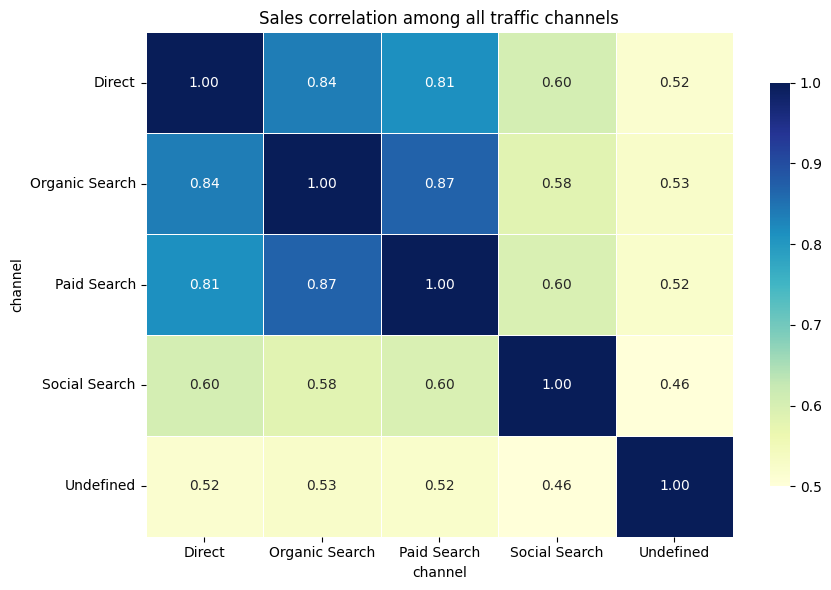

P-values for testing significance of correlations between channels:


channel,Direct,Organic Search,Paid Search,Social Search,Undefined
channel,,,,,
Direct,1.000000e+00,2.190417e-25,5.896432e-23,1.831888e-10,1.275436e-07
Organic Search,2.190417e-25,1.000000e+00,2.142000e-29,1.066192e-09,7.228212e-08
Paid Search,5.896432e-23,2.142000e-29,1.000000e+00,3.532281e-10,9.509605e-08
Social Search,1.831888e-10,1.066192e-09,3.532281e-10,1.000000e+00,5.161928e-06
Undefined,1.275436e-07,7.228212e-08,9.509605e-08,5.161928e-06,1.000000e+00


In [ ]:
# Aggregate sales by dates and channels (observed=True to avoid warnings)
df_channel_sales = df.groupby(['date', 'channel'], observed=True)['price'].sum().reset_index()

# Pivot table: dates as rows, channels as columns
df_pivot = df_channel_sales.pivot(index='date', columns='channel', values='price')

# Calculate correlation matrix
corr_matrix = df_pivot.corr()

# Calculate p-values for each pair of channels
p_values = df_pivot.corr(method=lambda x, y: pearsonr(x, y)[1])

# Visualize correlation with color scale from 0.8 to 1
plt.figure(figsize=(9, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='YlGnBu',
    vmin=0.5,
    vmax=1,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Sales correlation among all traffic channels')
plt.tight_layout()
plt.show()

# Output p-values for statistical significance check
print("P-values for testing significance of correlations between channels:")
display(p_values)


Аналіз кореляції продажів між різними каналами трафіку показав **статистично значущі зв’язки між усіма парами каналів** (p-значення значно нижчі за 0.001). Це свідчить про те, що зміни в обсягах продажів, що приходять з одного каналу, зазвичай супроводжуються схожими тенденціями в інших каналах.

## Кореляція продажів між різними категоріями з топ-5.


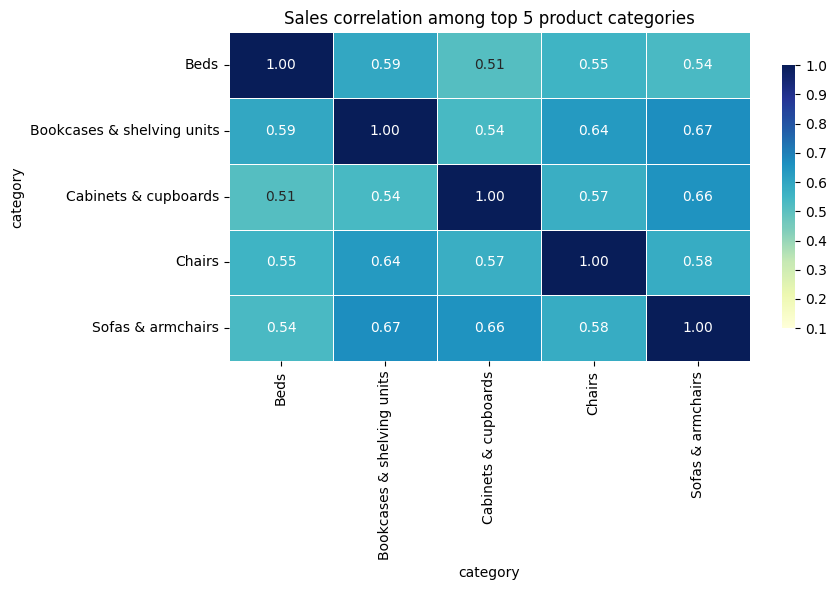

P-values for testing significance of correlations among top 5 product categories:


category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,1.000000e+00,1.154998e-09,2.910930e-07,2.079183e-08,7.687333e-08
Bookcases & shelving units,1.154998e-09,1.000000e+00,5.867224e-08,2.504552e-11,1.406973e-12
Cabinets & cupboards,2.910930e-07,5.867224e-08,1.000000e+00,5.465905e-09,3.415056e-12
Chairs,2.079183e-08,2.504552e-11,5.465905e-09,1.000000e+00,3.638833e-09
Sofas & armchairs,7.687333e-08,1.406973e-12,3.415056e-12,3.638833e-09,1.000000e+00


In [ ]:
# 1. Aggregate sales by dates and product categories
df_category_sales = df.groupby(['date', 'category'], observed=True)['price'].sum().reset_index()

# 2. Identify top 5 categories by total sales
top_5_categories = df_category_sales.groupby('category', observed=True)['price'].sum().nlargest(5).index.tolist()

# 3. Filter data by top 5 categories
df_top_cat = df_category_sales[df_category_sales['category'].isin(top_5_categories)]

# 4. Create pivot table: dates as rows, categories as columns
df_pivot_cat = df_top_cat.pivot(index='date', columns='category', values='price')

# 5. Calculate correlation matrix
corr_matrix_cat = df_pivot_cat.corr()

# 6. Calculate p-values for each pair of categories
p_values_cat = df_pivot_cat.corr(method=lambda x, y: pearsonr(x, y)[1])

# 7. Visualize correlation with color scale from 0.8 to 1, palette YlGnBu
plt.figure(figsize=(9, 6))
sns.heatmap(
    corr_matrix_cat,
    annot=True,
    cmap='YlGnBu',
    vmin=0.1,
    vmax=1,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Sales correlation among top 5 product categories')
plt.tight_layout()
plt.show()

# 8. Output p-values for statistical significance check
print("P-values for testing significance of correlations among top 5 product categories:")
display(p_values_cat)


Кореляційний аналіз продажів серед топ-5 категорій товарів **показав статистично значущі зв’язки між усіма категоріями** (p-значення значно менші за 0.001). Це свідчить про те, що попит на різні види меблів – Beds, Bookcases & shelving units, Cabinets & cupboards, Chairs, Sofas & armchairs – змінюється синхронно.

Можливо, такі кореляції відображають загальні сезонні тренди, маркетингові акції або схожі споживчі патерни серед покупців, які охоплюють одразу кілька категорій меблів.

#Статистичний аналіз відмінностей між групами
## Для користувачів verified та unverified


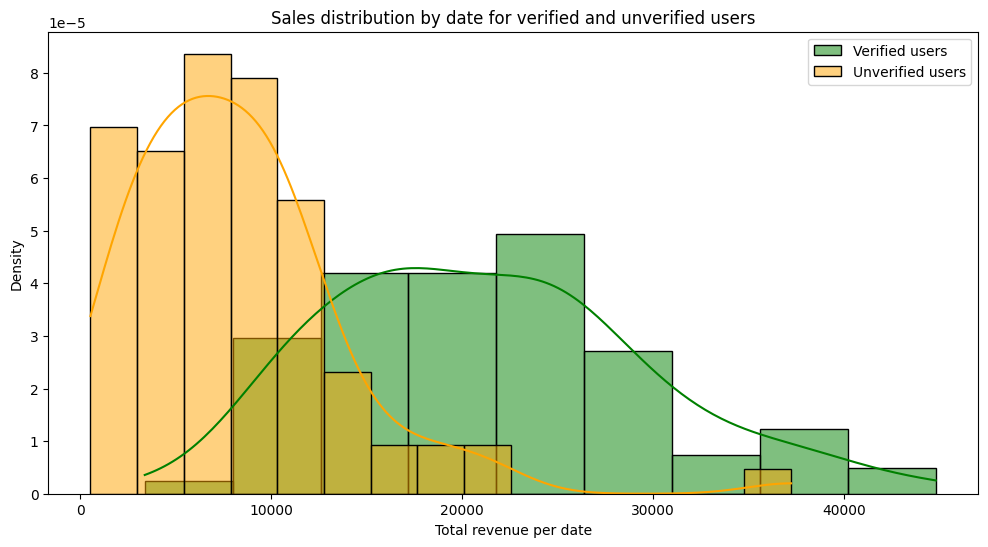

Has normal distribution 
sample1: True, sample2: False
Mann-Whitney U test statistic: 7147.0000, p-value: 0.0000
There is a statistically significant difference between the groups


('Mann-Whitney U test', np.float64(7147.0), np.float64(3.3672889331306305e-22))

In [ ]:
def check_normality(data, alpha=0.05):
    stat, p = shapiro(data)
    return p > alpha  # True if normal distribution

def compare_samples(sample1, sample2, alpha=0.05):
    # Check normality
    norm1 = check_normality(sample1)
    norm2 = check_normality(sample2)

    print(f"Has normal distribution \nsample1: {norm1}, sample2: {norm2}")

    # Choose test
    if norm1 and norm2:
        # Check homogeneity of variances
        stat_levene, p_levene = levene(sample1, sample2)
        equal_var = p_levene > alpha
        print(f"Levene test p-value: {p_levene:.4f} -> equal_var={equal_var}.")

        stat, p = ttest_ind(sample1, sample2, equal_var=equal_var)
        test_name = "t-test"
    else:
        stat, p = mannwhitneyu(sample1, sample2, alternative='two-sided')
        test_name = "Mann-Whitney U test"

    print(f"{test_name} statistic: {stat:.4f}, p-value: {p:.4f}")
    if p < alpha:
        print("There is a statistically significant difference between the groups")
    else:
        print("No statistically significant difference found")
    return test_name, stat, p

# --- Main part ---

# Group by date and user verification status
sales_verified = df[df['is_verified'] == True].groupby('date')['price'].sum()
sales_unverified = df[df['is_verified'] == False].groupby('date')['price'].sum()

# Merge by date so that both samples have the same dates (fill missing with zeros)
sales_df = sales_verified.to_frame('verified').join(
    sales_unverified.to_frame('unverified'), how='outer').fillna(0)

# Visualization
plt.figure(figsize=(12,6))
sns.histplot(sales_df['verified'], color='green', label='Verified users', kde=True, stat='density', bins='auto')
sns.histplot(sales_df['unverified'], color='orange', label='Unverified users', kde=True, stat='density', bins='auto')
plt.legend()
plt.title('Sales distribution by date for verified and unverified users')
plt.xlabel('Total revenue per date')
plt.ylabel('Density')
plt.show()

# Compare samples
compare_samples(sales_df['verified'], sales_df['unverified'])


Розподіл продажів для verified користувачів відповідає нормальному розподілу, тоді як для unverified – ні. За результатами тесту Манна-Вітні (Mann-Whitney U), між двома групами є статистично значуща різниця (p < 0.001).

Це свідчить, що поведінка verified та unverified користувачів за продажами відрізняється, й підтверджує, що підтвердження email впливає на рівень покупок.


## Для користувачів subscribed та unsubscribed


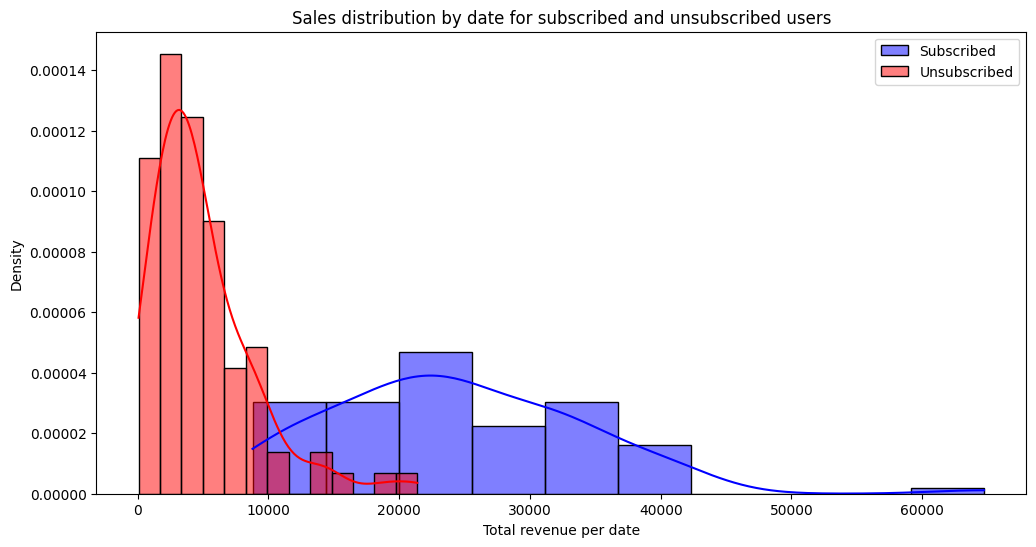

Has normal distribution 
sample1: False, sample2: False
Mann-Whitney U test statistic: 7619.0000, p-value: 0.0000
There is a statistically significant difference between the groups


('Mann-Whitney U test', np.float64(7619.0), np.float64(1.4787066504202697e-28))

In [ ]:
# Group by dates and subscription status
sales_subscribed = df[df['is_unsubscribed'] == False].groupby('date')['price'].sum()
sales_unsubscribed = df[df['is_unsubscribed'] == True].groupby('date')['price'].sum()

# Merge into a DataFrame by dates, fill missing with zeros
sales_unsub_df = sales_subscribed.to_frame('subscribed').join(
    sales_unsubscribed.to_frame('unsubscribed'), how='outer').fillna(0)

# Visualize distributions
plt.figure(figsize=(12,6))
sns.histplot(sales_unsub_df['subscribed'], color='blue', label='Subscribed', kde=True, stat='density', bins='auto')
sns.histplot(sales_unsub_df['unsubscribed'], color='red', label='Unsubscribed', kde=True, stat='density', bins='auto')
plt.legend()
plt.title('Sales distribution by date for subscribed and unsubscribed users')
plt.xlabel('Total revenue per date')
plt.ylabel('Density')
plt.show()

# Call sample comparison function
compare_samples(sales_unsub_df['subscribed'], sales_unsub_df['unsubscribed'])


Розподіли продажів у обох групах (subscribed і unsubscribed) не відповідають нормальному розподілу. Результати тесту Манна-Вітні показують статистично значущу різницю між ними (p < 0.001).

Це означає, що підписка на розсилку впливає на поведінку користувачів щодо продажів, і групи мають суттєві відмінності у своїх покупках.

## Для джерел трафіку

In [ ]:
from scipy.stats import shapiro, normaltest, kruskal, f_oneway
df_sales = df.groupby(['channel', 'date'], observed=True)['session_id'].nunique().reset_index(name='session_count')

# Step 2: Check normality of session_count distribution for each channel
channels = df_sales['channel'].unique()
normality_results = {}

for ch in channels:
    data = df_sales[df_sales['channel'] == ch]['session_count']

    stat_shapiro, p_shapiro = shapiro(data)
    stat_dagostino, p_dagostino = normaltest(data)

    normal = (p_shapiro > 0.05) and (p_dagostino > 0.05)

    normality_results[ch] = {
        'shapiro_p': p_shapiro,
        'dagostino_p': p_dagostino,
        'normal': normal
    }

    print(f"Channel: {ch} | Shapiro p = {p_shapiro:.4f}, D'Agostino p = {p_dagostino:.4f} | Normal: {normal}")

# Step 3: Decide whether to use parametric or non-parametric test
normality_violated = any(not res['normal'] for res in normality_results.values())

if normality_violated:
    print("\nUsing non-parametric Kruskal-Wallis test")
    stat, p = kruskal(*[df_sales[df_sales['channel'] == ch]['session_count'] for ch in channels])
else:
    print("\nUsing parametric ANOVA test")
    stat, p = f_oneway(*[df_sales[df_sales['channel'] == ch]['session_count'] for ch in channels])

print(f"Test statistic: {stat:.4f}, p-value = {p:.4f}")

if p < 0.05:
    print("Statistically significant differences found between traffic channels")
else:
    print("No statistically significant differences found between traffic channels")


Channel: Direct | Shapiro p = 0.0343, D'Agostino p = 0.0079 | Normal: False
Channel: Organic Search | Shapiro p = 0.0123, D'Agostino p = 0.0031 | Normal: False
Channel: Paid Search | Shapiro p = 0.0108, D'Agostino p = 0.0017 | Normal: False
Channel: Social Search | Shapiro p = 0.1413, D'Agostino p = 0.2144 | Normal: True
Channel: Undefined | Shapiro p = 0.0546, D'Agostino p = 0.0402 | Normal: False

Using non-parametric Kruskal-Wallis test
Test statistic: 368.9806, p-value = 0.0000
Statistically significant differences found between traffic channels


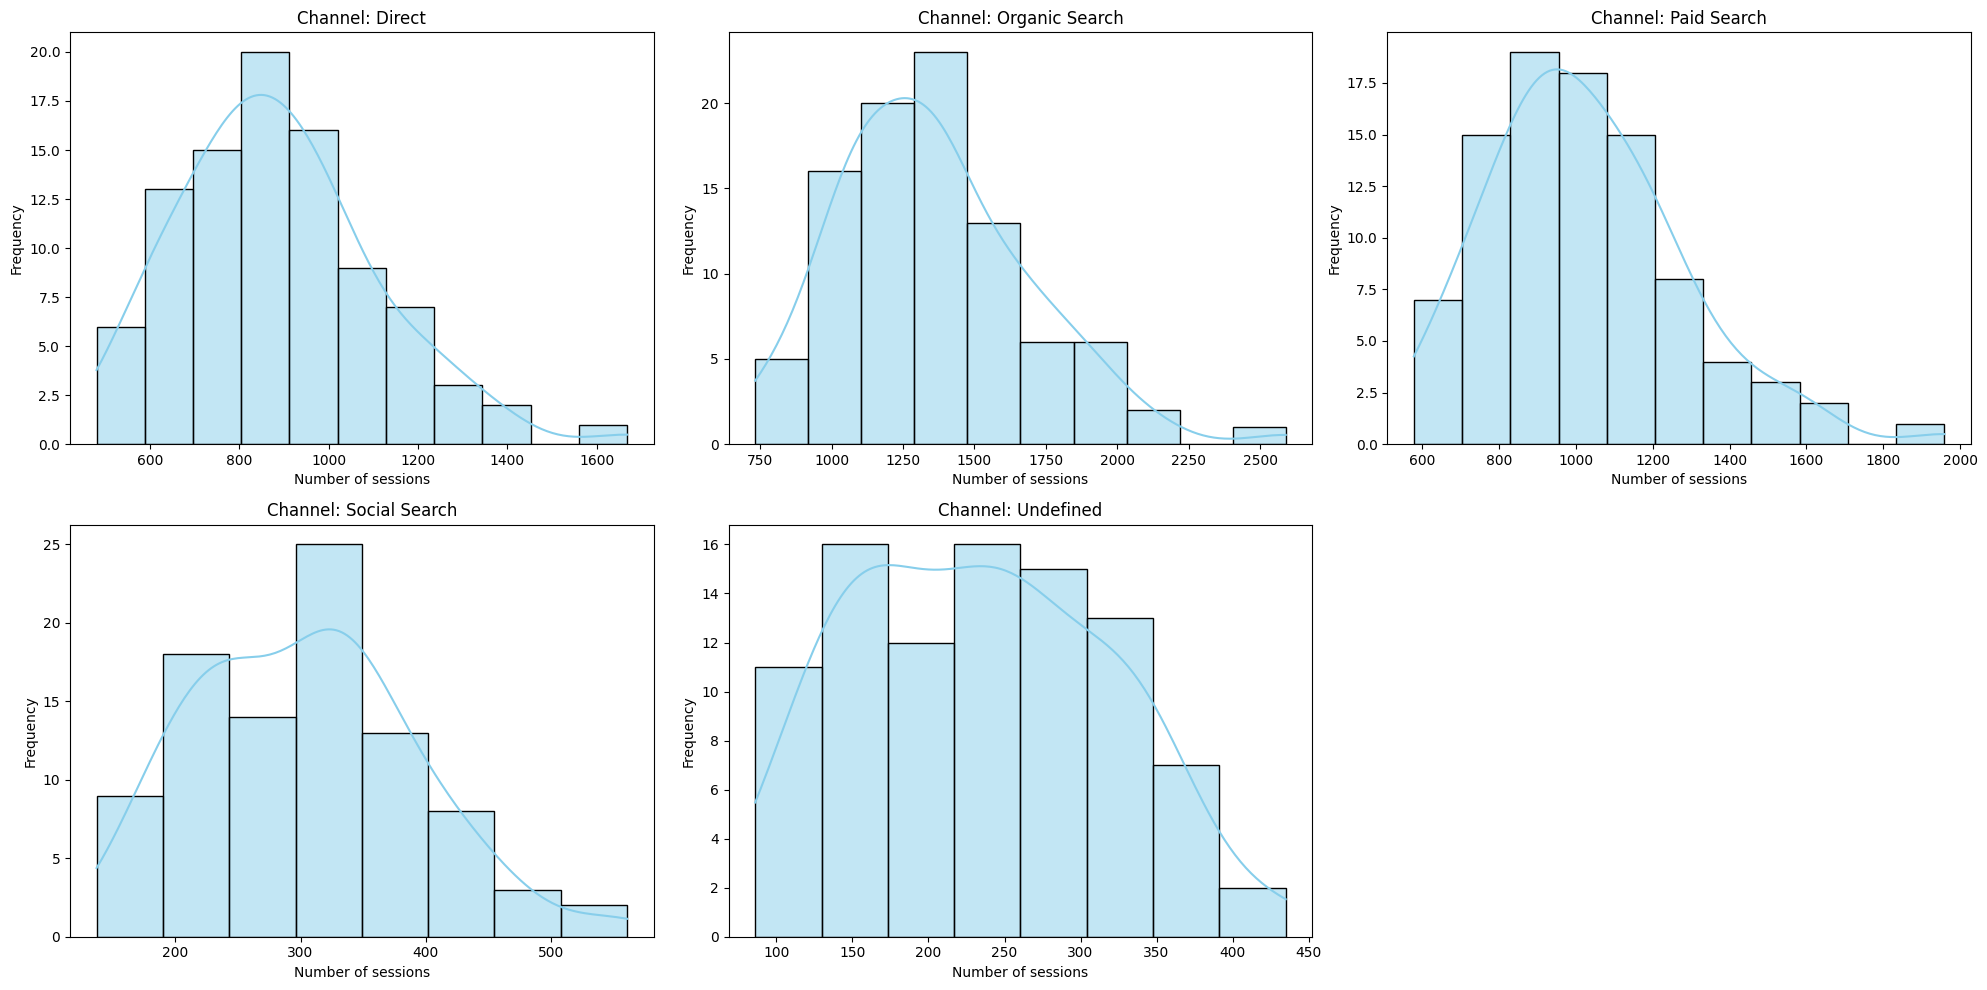

In [ ]:
plt.figure(figsize=(20, 10))

for i, ch in enumerate(channels, 1):
    data = df_sales[df_sales['channel'] == ch]['session_count']
    plt.subplot(2, 3, i)
    sns.histplot(data, bins='auto', kde=True, color='skyblue')
    plt.title(f"Channel: {ch}")
    plt.xlabel('Number of sessions')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Розподіли кількості сесій у більшості каналів (Direct, Organic Search, Paid Search, Undefined) **не відповідають нормальному**, лише **Social Search** має нормальний розподіл. Через це було застосовано непараметричний тест Крускала-Уолліса.

Результат тесту (p < 0.001) свідчить **про статистично значущі відмінності** в кількості сесій між різними каналами трафіку.

Отже, трафік різних каналів **суттєво відрізняється** за кількістю сесій, що може впливати на стратегії залучення відвідувачів.

## Порівняння частки органічного трафіку в Europe та Americas

=== Comparison of organic traffic share ===
Americas: 35.55% (68671 out of 193179)
Europe: 35.61% (23195 out of 65135)

Z-statistic: -0.2895
P-value: 0.7722
 The difference is NOT statistically significant (no differences).


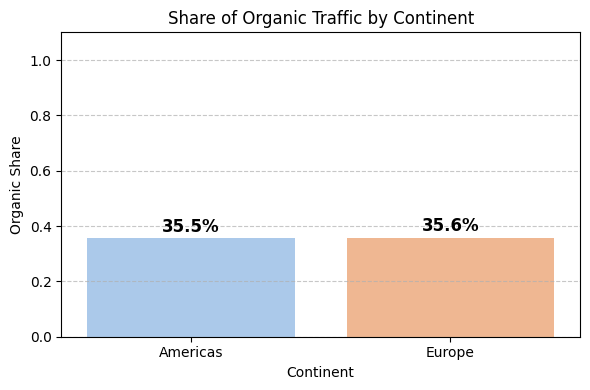

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# 1. Filter only the required continents and non-null values
df_test = df[df['continent'].isin(['Europe', 'Americas'])].copy()
df_test = df_test[df_test['channel'].notna()]

# 2. Remove unused categories if they exist
if isinstance(df_test['continent'].dtype, pd.CategoricalDtype):
    df_test['continent'] = df_test['continent'].cat.remove_unused_categories()
if isinstance(df_test['channel'].dtype, pd.CategoricalDtype):
    df_test['channel'] = df_test['channel'].cat.remove_unused_categories()

# 3. Total number of unique sessions per continent
total_sessions = df_test.groupby('continent', observed=True)['session_id'].nunique()

# 4. Number of organic sessions per continent
organic_sessions = df_test[df_test['channel'] == 'Organic Search'] \
    .groupby('continent', observed=True)['session_id'].nunique()

# 5. Create shares_df for visualization
shares_df = pd.DataFrame({
    'continent': total_sessions.index,
    'organic_share': organic_sessions.reindex(total_sessions.index).fillna(0).values / total_sessions.values
})

# 6. Perform Z-test
count = organic_sessions.reindex(total_sessions.index).fillna(0).astype(int).values
nobs = total_sessions.values
z_stat, p_val = proportions_ztest(count, nobs)

# 7. Output the result
print("=== Comparison of organic traffic share ===")
for region in total_sessions.index:
    share = count[total_sessions.index.get_loc(region)] / nobs[total_sessions.index.get_loc(region)]
    print(f"{region}: {share:.2%} ({count[total_sessions.index.get_loc(region)]} out of {nobs[total_sessions.index.get_loc(region)]})")

print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print(" The difference is statistically significant (there are differences).")
else:
    print(" The difference is NOT statistically significant (no differences).")

# 8. Visualization
plt.figure(figsize=(6, 4))
sns.barplot(
    data=shares_df,
    x='continent',
    y='organic_share',
    hue='continent',
    palette='pastel',
    legend=False
)

# Add percentage values on bars
for i, row in shares_df.iterrows():
    plt.text(
        x=i,
        y=row['organic_share'] + 0.01,
        s=f"{row['organic_share']:.1%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title('Share of Organic Traffic by Continent')
plt.ylabel('Organic Share')
plt.xlabel('Continent')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Доля органічного трафіку складає 35.55% у Америці та 35.61% у Європі, **що практично однаково**.
За результатами Z-тесту для пропорцій, **статистично значущої різниці між цими показниками не виявлено** (p = 0.7722).

Отже, частка органічних сесій у цих двох регіонах **не відрізняється**, що свідчить про подібну структуру джерел трафіку.

#Загальний висновок

Компанія демонструє доволі сильні результати в залученні користувачів та обсягах продажів, особливо на ринку **Америки**. Серед товарних категорій лідерами за доходом є **меблі для вітальні, зокрема дивани та крісла**. Ця категорія має високий рівень прибутковості, хоча не є найпопулярнішою за кількістю продажів, що **свідчить про значний потенціал для зростання** через акції чи знижки.

Натомість найбільшу кількість продажів має категорія **"Книжкові шафи та полиці"**, яка при цьому приносить менший дохід. Тут варто **приділити увагу ціновій політиці** - можливо, підвищення цін призведе до кращої маржинальності без втрати попиту.

Щодо трафіку - **органічні пошукові запити залишаються найважливішим каналом**, але і платний та прямий трафік дають вагомий внесок у продажі. **Спостерігається чіткий зв’язок між кількістю сеансів і обсягом реалізації** товарів.

Користувачі переважно здійснюють покупки з **настільних пристроїв** (більшість — через браузер **Chrome**), але мобільні користувачі (здебільшого **iPhone**) також суттєво впливають на конверсії. **Джерела трафіку схожі**, незалежно від типу пристрою, тож маркетинг можна тримати у єдиній стратегії.

Незважаючи на велику кількість зареєстрованих акаунтів, їхній внесок у загальні замовлення **невеликий**. Реєстрація та підписка **не дають користувачам очевидних переваг**, і це варто змінити - покращити процес реєстрації, стимулювати повторні покупки через програму лояльності.

Щодо сезонності — спостерігається чіткий місячний цикл продажів **із піком у грудні**, що відповідає різдвяним святам. Ця тенденція простежується у всіх ключових регіонах.

##**Рекомендації**:

* Оптимізувати процес реєстрації та зробити підписку більш привабливою для користувачів.

* Акцентувати маркетинг на органічному трафіку та розвивати платні канали, особливо у топ-5 країнах.

* Запустити A/B тести для акцій на дивани та крісла, щоб збільшити їхню популярність і прибутковість.

* Переглянути цінову політику для книжкових шаф та полиць і протестувати підвищення цін.

* Провести більш глибокий аналіз поведінки клієнтів, щоб краще розуміти повторні покупки та середній чек.

* Використовувати сезонні тренди для ефективнішого планування акцій і запасів.

Загалом, компанія має гарну базу, але є великий потенціал для зростання через більш точну роботу з користувачами і таргетовані маркетингові рішення.

#Посилання на візуалізацію в Tableau
#[Dashboard Tableau](https://public.tableau.com/shared/DGGBDSJMQ?:display_count=n&:origin=viz_share_link)